In [2]:
import numpy as np
from scipy import interpolate
import time
import math
import matplotlib.pyplot as plt
# from misc.golden_section_search import Search

In [282]:
"""
Michael Pham
May 2025

much thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational
Methods and Applications, Algorithm 10.1.1

version 5 with K, Z, H, L  state variable
added hetero in human capital levels and misperception
no consumption tax
"""

'\nMichael Pham\nMay 2025\n\nmuch thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational\nMethods and Applications, Algorithm 10.1.1\n\nversion 5 with K, Z, H, L  state variable\nadded optimization of child human capital\nno consumption tax\n'

In [284]:
exp = np.e
log = math.log

In [285]:
# Parameters - households and firms
beta = 0.935  # discount factor
eta = 2.0    # coefficient of relative risk aversion
gamma = 2  # disutility from working
alpha = 0.33 # capital share in production
delta = 0.1  # depreciation rate
# omega = 0.1  # parent education time factor
phi_p = 0.324  # share of parental input in education
psi_e = 0.29  # CES parameter for education inputs
theta_I = 0.5  # human capital investment effectiveness
varsigma_g = 1
varsigma_p = 1


# phi_p = 0.324
# varsigma_p = 1
# varsigma_g = 1
# theta_I = 0.5
# psi_e = 0.29
# I_e = (0.06 * Y)
# I_e_mean = (0.035*Y)
# e_mean = 0.01
# e_min = 0.001
# e_max = 1





tfp = 1      #total factor productivity
small = 0.00001
neg = -1e10

#Parameters - government
tau = 0.15
Ie_gdp = 0.06 # public education investment as percent of GDP
Iz_gdp = 0.06 # public infrastructure investment as percent of GDP percent of GDP
sigma_bar = 0.3  # public investment inefficiency
G_gdp = 0.07      # grants (as a fraction of GDP)
psi = 0.1   # public infrastructure elasticity
# nu = 0.6     # debt-to-GDP ratio limit

rho_true = -1
rho_percieved = 1

# Initial guesses
# K_init = 1
# H_init = 1
# L_init = 0.2
# Z_init = 1
# tau_init = 0.15  # Initial guess for tax rate
# T_init = 0.1  # Initial guess for transfers
# D_init = 0

# Grid spec
na = 5  # number of points in capital grid
nh = 5   # number of points in human capital grid
# nZ = 20   # number of points in public infrastructure grid
# Kmin = 0
# Kmax = 10
# hmin = 0
# hmax = 10
# Zmin = 0
# Zmax = 10

k_start = 0
k_min, k_max = 0, 2
k_grid =  np.linspace(k_min, k_max, na)   # asset grid 
k_eps = (k_grid[1]-k_grid[0])/na    #  test for corner solution
phi = 0.8           # updating of the aggregate capital stock K in outer loop
tolerance = 0.001        # percentage deviation of final solution 
tolerance_gs = 1e-10       # tolerance for golden section search 
max_iters = 30             # maximum number of iteration over K


# h_min, h_max = 1, 1500
h_min, h_max = 1, 3


# Number of periods
periods = 6
child_periods = 4

In [286]:
l_init = 0.2
r_init = beta**(-1) - 1

Production Equations

In [287]:
def production(Z_prev, K_prev, H, L):
    """
    production function (eq 1 mod)

    params: K_t-1, H_t, L_t
    returns: Y
    """
    return tfp * Z_prev**psi * K_prev**(alpha-psi) * (H*L)**(1-alpha-psi)

def wage_rate(Z_prev, K_prev, H, L):
    """
    marginal product of labor (eq 2 mod)

    params: K_t-1, H_t, L_t
    returns: w_t
    """
    return tfp * Z_prev**psi * (1-alpha-psi) * (K_prev)**(alpha-psi) * (H*L)**(-alpha-psi)

def interest_rate(Z_prev, K_prev, H, L):
    """
    marginal product of capital minus depreciation (eq 3 mod + interest steady state)

    params: K_t-1, H_t, L_t
    returns: r_t 
    """
    return tfp * (alpha -psi) * Z_prev**psi * (H*L)**(1-alpha-psi) * K_prev**(alpha-1-psi) - delta

Human Capital Equations

In [288]:
def human_capital_formation(h_c, e_p, I_e, e_mean, I_e_mean):
    """

    params: 
    returns: 
    """
    I_c = (phi_p * (varsigma_p * (e_p / e_mean)) ** psi_e + (1-phi_p) * (varsigma_g * I_e/I_e_mean) ** psi_e ) ** (1/psi_e)
    
    return ((theta_I * I_c ** rho_percieved) + ((1-theta_I) * h_c ** rho_percieved)) ** (1/rho_percieved)


def human_capital_formation_true(h_c, e_p, I_e, e_mean, I_e_mean):
    """

    params: 
    returns: 
    """
    I_c = (phi_p * (varsigma_p * (e_p / e_mean)) ** psi_e + (1-phi_p) * (varsigma_g * I_e/I_e_mean) ** psi_e ) ** (1/psi_e)
    
    return ((theta_I * I_c ** rho_true) + ((1-theta_I) * h_c ** rho_true)) ** (1/rho_true)

In [289]:
"""
Michael Pham
May 2025

much thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational
Methods and Applications, Algorithm 10.1.1

version 5 with K, Z, H, L  state variable
added optimization of child human capital
no consumption tax
"""

'\nMichael Pham\nMay 2025\n\nmuch thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational\nMethods and Applications, Algorithm 10.1.1\n\nversion 5 with K, Z, H, L  state variable\nadded optimization of child human capital\nno consumption tax\n'

Government Equations

In [290]:
def transfer(K_prev, H, L, G, tau, w, r):
  """
  government budget (eq 6 mod)
  assumes balanced budget, no borrowing

  params: K_t-1, H_t, L_t, G, tau, w_t, r_t
  returns: T (transfers)
  """
  tax_revenue = tau*w*H*L + tau*r*K_prev
  total_revenue = tax_revenue + G
  return total_revenue #- Y*Ie_gdp

Household Equations

In [291]:
def utility(c, l):
  """
  household utility function (eq 8)
  adds modified case of when full labor, so utility is not 0

  params: c_t, l_t
  returns: utility
  """

  if l == 1:
    return np.log(c+ small) + gamma * np.log(l)

  return (((c+small) * (1-l) ** gamma) ** (1-eta) - 1) / (1-eta)


# def next_value_function(k):
#   return vr_polate(k)

def labor_foc(k, k_prev, h, w, r, tau, T):

  l = (1/(1+gamma)) * ( 1 - (gamma * (((1+r) * k_prev - tau * r * k_prev + T - k))/((1-tau)*w*h)))

  if l < 0: # corner solution 0<=n<=1
    l = 0
  elif l > 1: # corner solution
    l = 1

  return l


def value_function(next_value_interpolator, k, k_prev, h, w, r, tau, T):
  """
  household bellman equation (eq 14)
  
  params: k_t, k_t-1, c_t, l_t, h_t, w_t, r_t, tau, T
  returns: value of this period's bellman equation
  """
  l = labor_foc(k, k_prev, h, w, r, tau, T)


  c = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
  if c <= 0:
    return neg
  # print(f"in value function, c: {c}, l, {l}, interpolator, {next_value_interpolator}")
  return utility(c, l) + beta * next_value_interpolator(k)

def consumption(k_prev, k, h, l, w, r, tau, T):
  return (1-tau)*w*h*l + (1+ r)*k_prev - tau*r*max(k_prev, 0) + T - k

def consumption_parent(k_prev, k, h, l, w, r, tau, T, e):
  return (1-tau)*w*h*l + (1+ r)*k_prev - tau*r*max(k_prev, 0) + T - k - e


def final_child_value(hc):
  return 30 * hc


def value_function_parent_final(next_value_interpolator, k, k_prev, h, w, r, tau, T, hc, I_e, e_mean, I_e_mean):
  """
  household bellman equation (eq 14)
  
  params: k_t, k_t-1, c_t, l_t, h_t, w_t, r_t, tau, T
  returns: value of this period's bellman equation
  """
  l = labor_foc(k, k_prev, h, w, r, tau, T)

  # print(f"hc = {hc}")

  c_total = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
  if c_total <= 0:
    return neg
  
  #do GSS to find e*
  # Golden section search to find optimal c
  a = 0  # minimum consumption
  b = c_total  # maximum consumption
  rg = (3.0 - np.sqrt(5.0)) / 2.0  # golden ratio
  
  c = a + rg * (b - a)
  e_c = c_total - c
  hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
  # print(f"hc_next_c = {hc_next_c}")
  val_c = utility(c, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_c)
  # print(f"utility  = {utility(c, l)}")
  # print(f"nexthc {final_child_value(hc_next_c)}") #errored
  # print(f"next_val {next_value_interpolator(k)}")
  # print(f"val_c {val_c}")

  d = a + (1.0 - rg) * (b - a)
  e_d = c_total - d
  hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
  val_d = utility(d, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_d)
  # print(f"val_d {val_d}")



  tol = 1e-6
  diff = 1e4
  
  while diff > tol:
      if val_c >= val_d:
          b = d
          d = c
          val_d = val_c
          c = a + rg * (b - a)
          e_c = c_total - c
          hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
          val_c = utility(c, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_c)
      else:
          a = c
          c = d
          val_c = val_d
          d = a + (1.0 - rg) * (b - a)
          e_d = c_total - d
          hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
          val_d = utility(d, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_d)
      
      diff = b - a
  
  c = (a + b) / 2.0
  e = c_total - c
  hc_next = human_capital_formation(h_c=hc, e_p=e, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
  value = utility(c, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next)
  # print(f"in value function, c: {c}, l, {l}, interpolator, {next_value_interpolator}")

  
  return value




def value_function_parent(next_value_interpolator, k, k_prev, h, w, r, tau, T, hc, I_e, e_mean, I_e_mean):
  """
  household bellman equation (eq 14)
  
  params: k_t, k_t-1, c_t, l_t, h_t, w_t, r_t, tau, T
  returns: value of this period's bellman equation
  """
  l = labor_foc(k, k_prev, h, w, r, tau, T)



  c_total = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
  if c_total <= 0:
    return neg
  
  #do GSS to find e*
  # Golden section search to find optimal c
  a = 0  # minimum consumption
  b = c_total  # maximum consumption
  rg = (3.0 - np.sqrt(5.0)) / 2.0  # golden ratio
  
  c = a + rg * (b - a)
  e_c = c_total - c
  hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
  val_c = utility(c, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_c)
  
  d = a + (1.0 - rg) * (b - a)
  e_d = c_total - d
  hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
  val_d = utility(d, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_d)
  
  tol = 1e-6
  diff = 1e4
  
  while diff > tol:
      if val_c >= val_d:
          b = d
          d = c
          val_d = val_c
          c = a + rg * (b - a)
          e_c = c_total - c
          hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
          val_c = utility(c, l) + beta * next_value_interpolator(k) 
      else:
          a = c
          c = d
          val_c = val_d
          d = a + (1.0 - rg) * (b - a)
          e_d = c_total - d
          hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
          val_d = utility(d, l) + beta * next_value_interpolator(k) 
      
      diff = b - a
  
  c = (a + b) / 2.0
  e = c_total - c
  hc_next = human_capital_formation(h_c=hc, e_p=e, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
  value = utility(c, l) + beta * next_value_interpolator(k) 
  # print(f"in value function, c: {c}, l, {l}, interpolator, {next_value_interpolator}")
  
  return value




def e_star_parent_final(next_value_interpolator, k, k_prev, h, w, r, tau, T, hc, I_e, e_mean, I_e_mean):
  """
  household bellman equation (eq 14)
  
  params: k_t, k_t-1, c_t, l_t, h_t, w_t, r_t, tau, T
  returns: value of this period's bellman equation
  """
  l = labor_foc(k, k_prev, h, w, r, tau, T)

  # print(f"hc = {hc}")

  c_total = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
  if c_total <= 0:
    return 0
  
  #do GSS to find e*
  # Golden section search to find optimal c
  a = 0  # minimum consumption
  b = c_total  # maximum consumption
  rg = (3.0 - np.sqrt(5.0)) / 2.0  # golden ratio
  
  c = a + rg * (b - a)
  e_c = c_total - c
  hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
  # print(f"hc_next_c = {hc_next_c}")
  val_c = utility(c, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_c)
  # print(f"utility  = {utility(c, l)}")
  # print(f"nexthc {final_child_value(hc_next_c)}") #errored
  # print(f"next_val {next_value_interpolator(k)}")
  # print(f"val_c {val_c}")

  d = a + (1.0 - rg) * (b - a)
  e_d = c_total - d
  hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
  val_d = utility(d, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_d)
  # print(f"val_d {val_d}")



  tol = 1e-6
  diff = 1e4
  
  while diff > tol:
      if val_c >= val_d:
          b = d
          d = c
          val_d = val_c
          c = a + rg * (b - a)
          e_c = c_total - c
          hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
          val_c = utility(c, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_c)
      else:
          a = c
          c = d
          val_c = val_d
          d = a + (1.0 - rg) * (b - a)
          e_d = c_total - d
          hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
          val_d = utility(d, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_d)
      
      diff = b - a
  
  c = (a + b) / 2.0
  e = c_total - c
  hc_next = human_capital_formation(h_c=hc, e_p=e, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
  value = utility(c, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next)
  # print(f"in value function, c: {c}, l, {l}, interpolator, {next_value_interpolator}")

  
  return e




def e_star_parent(next_value_interpolator, k, k_prev, h, w, r, tau, T, hc, I_e, e_mean, I_e_mean):
  """
  household bellman equation (eq 14)
  
  params: k_t, k_t-1, c_t, l_t, h_t, w_t, r_t, tau, T
  returns: value of this period's bellman equation
  """
  l = labor_foc(k, k_prev, h, w, r, tau, T)



  c_total = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
  if c_total <= 0:
    return 0
  
  #do GSS to find e*
  # Golden section search to find optimal c
  a = 0  # minimum consumption
  b = c_total  # maximum consumption
  rg = (3.0 - np.sqrt(5.0)) / 2.0  # golden ratio
  
  c = a + rg * (b - a)
  e_c = c_total - c
  hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
  val_c = utility(c, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_c)
  
  d = a + (1.0 - rg) * (b - a)
  e_d = c_total - d
  hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
  val_d = utility(d, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_d)
  
  tol = 1e-6
  diff = 1e4
  
  while diff > tol:
      if val_c >= val_d:
          b = d
          d = c
          val_d = val_c
          c = a + rg * (b - a)
          e_c = c_total - c
          hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
          val_c = utility(c, l) + beta * next_value_interpolator(k) 
      else:
          a = c
          c = d
          val_c = val_d
          d = a + (1.0 - rg) * (b - a)
          e_d = c_total - d
          hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
          val_d = utility(d, l) + beta * next_value_interpolator(k) 
      
      diff = b - a
  
  c = (a + b) / 2.0
  e = c_total - c
  hc_next = human_capital_formation(h_c=hc, e_p=e, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
  value = utility(c, l) + beta * next_value_interpolator(k) 
  # print(f"in value function, c: {c}, l, {l}, interpolator, {next_value_interpolator}")
  
  return e

Simulation

Agent human capital summary:
Mean: 1.0126
Std Dev: 0.2648
Min: 0.5000
Max: 1.8754


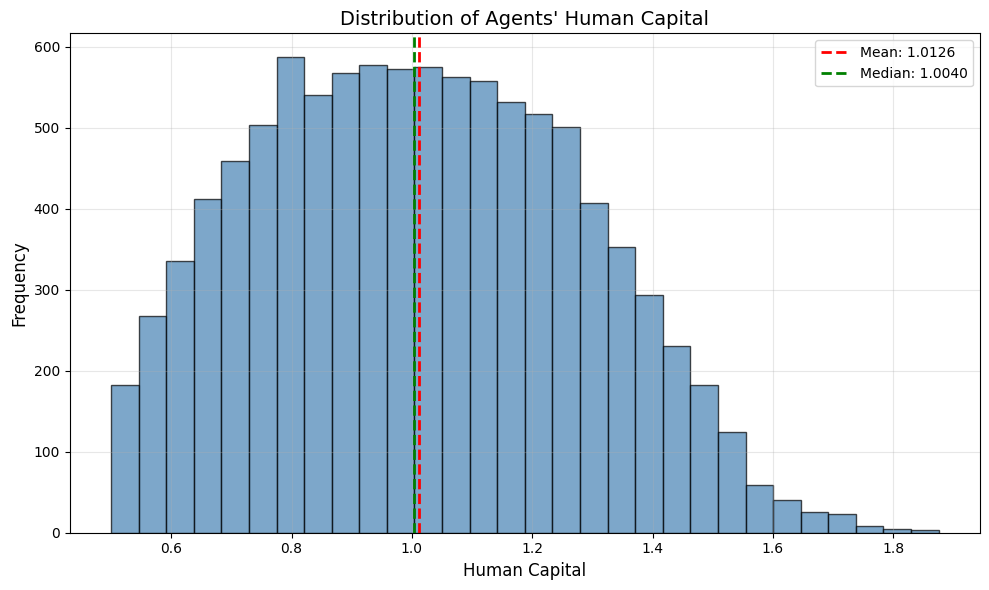

In [13]:
agents = 10000
min_h = 0.5
mu_1 = 1.2
mu_2 = 0.8

def sample_from_mixture_of_normals(n_agents, means=[mu_1, mu_2], weights=[0.5, 0.5], std_dev=0.2):
    """
    Sample from a mixture of normal distributions.
    
    Parameters:
    -----------
    n_agents : int
        Number of agents to sample
    means : list
        List of means for each normal distribution
    weights : list
        List of weights for each normal distribution (should sum to 1)
    std_dev : float or list
        Standard deviation(s) for the normal distributions
        If float, the same std_dev is used for all distributions
        If list, should have same length as means
    
    Returns:
    --------
    samples : numpy array
        Array of samples from the mixture distribution
    """
    # Normalize weights to sum to 1
    weights = np.array(weights) / np.sum(weights)
    
    # Convert std_dev to list if it's a scalar
    if isinstance(std_dev, (int, float)):
        std_dev = [std_dev] * len(means)
    
    # Check that inputs have consistent lengths
    assert len(means) == len(weights) == len(std_dev), "means, weights, and std_dev must have the same length"
    
    # Choose which distribution to sample from for each agent
    distribution_indices = np.random.choice(len(means), size=n_agents, p=weights)
    
    # Generate samples
    samples = np.zeros(n_agents)
    for i, idx in enumerate(distribution_indices):
        samples[i] = np.random.normal(means[idx], std_dev[idx])
        # Resample if below minimum human capital threshold
        while samples[i] < min_h:
            samples[i] = np.random.normal(means[idx], std_dev[idx])
    
    return samples

# Sample agents from mixture of normals
# Default is a single normal with mean 1 and std_dev 0.2
agent_human_capital = sample_from_mixture_of_normals(agents)

# Example of using a mixture of two normals:
# agent_human_capital = sample_from_mixture_of_normals(
#     agents, 
#     means=[0.8, 1.2],  # Two different means
#     weights=[0.6, 0.4],  # 60% from first distribution, 40% from second
#     std_dev=[0.15, 0.25]  # Different standard deviations
# )

# Print summary statistics
print(f"Agent human capital summary:")
print(f"Mean: {np.mean(agent_human_capital):.4f}")
print(f"Std Dev: {np.std(agent_human_capital):.4f}")
print(f"Min: {np.min(agent_human_capital):.4f}")
print(f"Max: {np.max(agent_human_capital):.4f}")

# Plot the distribution of human capital
plt.figure(figsize=(10, 6))
plt.hist(agent_human_capital, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
plt.title('Distribution of Agents\' Human Capital', fontsize=14)
plt.xlabel('Human Capital', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)

# Add vertical line for mean
plt.axvline(np.mean(agent_human_capital), color='red', linestyle='dashed', linewidth=2, 
            label=f'Mean: {np.mean(agent_human_capital):.4f}')

# Add vertical line for median
plt.axvline(np.median(agent_human_capital), color='green', linestyle='dashed', linewidth=2,
            label=f'Median: {np.median(agent_human_capital):.4f}')

plt.legend()
plt.tight_layout()
plt.show()

In [292]:
# def value_function_parent_final(next_value_interpolator, k, k_prev, h, w, r, tau, T, hc, I_e, e_mean, I_e_mean):
#     """
#     Value function for parent in final period with child human capital investment
#     """
#     # Add reasonable bounds for inputs
#     h = np.clip(h, 0, 1e6)
#     hc = np.clip(hc, 0, 1e6)
    
#     l = labor_foc(k, k_prev, h, w, r, tau, T)
    
#     # Add bounds checking for total resources
#     c_total = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
#     if c_total <= 0:
#         return neg
#     if c_total > 1e6:  # Add reasonable upper bound
#         print(f"Warning: Large total resources: {c_total}")
#         c_total = 1e6
    
#     # Set reasonable bounds for education investment
#     max_e = min(c_total, 0.5 * c_total)  # Cap education at 50% of total resources
    
#     # Golden section search with bounds
#     a = 0
#     b = c_total
#     rg = (3.0 - np.sqrt(5.0)) / 2.0
    
#     c = a + rg * (b - a)
#     e_c = min(c_total - c, max_e)
#     hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
    
#     # Validate human capital formation
#     if not np.isfinite(hc_next_c):
#         print(f"Warning: Invalid human capital formation with e_c={e_c}")
#         hc_next_c = hc
    
#     val_c = utility(c, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_c)
    
#     d = a + (1.0 - rg) * (b - a)
#     e_d = min(c_total - d, max_e)
#     hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
    
#     if not np.isfinite(hc_next_d):
#         print(f"Warning: Invalid human capital formation with e_d={e_d}")
#         hc_next_d = hc
    
#     val_d = utility(d, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_d)
    
#     tol = 1e-6
#     max_iter = 100
#     iter_count = 0
#     diff = 1e4
    
#     while diff > tol and iter_count < max_iter:
#         iter_count += 1
        
#         if val_c >= val_d:
#             b = d
#             d = c
#             val_d = val_c
#             c = a + rg * (b - a)
#             e_c = min(c_total - c, max_e)
#             hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
            
#             if not np.isfinite(hc_next_c):
#                 print(f"Warning: Invalid human capital formation with e_c={e_c}")
#                 hc_next_c = hc
            
#             val_c = utility(c, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_c)
#         else:
#             a = c
#             c = d
#             val_c = val_d
#             d = a + (1.0 - rg) * (b - a)
#             e_d = min(c_total - d, max_e)
#             hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
            
#             if not np.isfinite(hc_next_d):
#                 print(f"Warning: Invalid human capital formation with e_d={e_d}")
#                 hc_next_d = hc
            
#             val_d = utility(d, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_d)
        
#         diff = b - a
    
#     if iter_count >= max_iter:
#         print(f"Warning: Maximum iterations reached in golden section search")
    
#     c = (a + b) / 2.0
#     e = min(c_total - c, max_e)
#     hc_next = human_capital_formation(h_c=hc, e_p=e, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
    
#     if not np.isfinite(hc_next):
#         print(f"Warning: Invalid final human capital formation")
#         hc_next = hc
    
#     value = utility(c, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next)
    
#     return value

# def value_function_parent(next_value_interpolator, k, k_prev, h, w, r, tau, T, hc, I_e, e_mean, I_e_mean):
#     """
#     Value function for parent in non-final period with child human capital investment
#     """
#     # Add reasonable bounds for inputs
#     h = np.clip(h, 0, 1e6)
#     hc = np.clip(hc, 0, 1e6)
    
#     l = labor_foc(k, k_prev, h, w, r, tau, T)
    
#     c_total = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
#     if c_total <= 0:
#         return neg
#     if c_total > 1e6:
#         print(f"Warning: Large total resources: {c_total}")
#         c_total = 1e6
    
#     max_e = min(c_total, 0.5 * c_total)
    
#     a = 0
#     b = c_total
#     rg = (3.0 - np.sqrt(5.0)) / 2.0
    
#     c = a + rg * (b - a)
#     e_c = min(c_total - c, max_e)
#     hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
    
#     if not np.isfinite(hc_next_c):
#         print(f"Warning: Invalid human capital formation with e_c={e_c}")
#         hc_next_c = hc
    
#     val_c = utility(c, l) + beta * next_value_interpolator(k)
    
#     d = a + (1.0 - rg) * (b - a)
#     e_d = min(c_total - d, max_e)
#     hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
    
#     if not np.isfinite(hc_next_d):
#         print(f"Warning: Invalid human capital formation with e_d={e_d}")
#         hc_next_d = hc
    
#     val_d = utility(d, l) + beta * next_value_interpolator(k)
    
#     tol = 1e-6
#     max_iter = 100
#     iter_count = 0
#     diff = 1e4
    
#     while diff > tol and iter_count < max_iter:
#         iter_count += 1
        
#         if val_c >= val_d:
#             b = d
#             d = c
#             val_d = val_c
#             c = a + rg * (b - a)
#             e_c = min(c_total - c, max_e)
#             hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
            
#             if not np.isfinite(hc_next_c):
#                 print(f"Warning: Invalid human capital formation with e_c={e_c}")
#                 hc_next_c = hc
            
#             val_c = utility(c, l) + beta * next_value_interpolator(k)
#         else:
#             a = c
#             c = d
#             val_c = val_d
#             d = a + (1.0 - rg) * (b - a)
#             e_d = min(c_total - d, max_e)
#             hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
            
#             if not np.isfinite(hc_next_d):
#                 print(f"Warning: Invalid human capital formation with e_d={e_d}")
#                 hc_next_d = hc
            
#             val_d = utility(d, l) + beta * next_value_interpolator(k)
        
#         diff = b - a
    
#     if iter_count >= max_iter:
#         print(f"Warning: Maximum iterations reached in golden section search")
    
#     c = (a + b) / 2.0
#     e = min(c_total - c, max_e)
#     hc_next = human_capital_formation(h_c=hc, e_p=e, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
    
#     if not np.isfinite(hc_next):
#         print(f"Warning: Invalid final human capital formation")
#         hc_next = hc
    
#     value = utility(c, l) + beta * next_value_interpolator(k)
    
#     return value

# def e_star_parent_final(next_value_interpolator, k, k_prev, h, w, r, tau, T, hc, I_e, e_mean, I_e_mean):
#     """
#     Optimal education investment for parent in final period
#     """
#     # Add reasonable bounds for inputs
#     h = np.clip(h, 0, 1e6)
#     hc = np.clip(hc, 0, 1e6)
    
#     l = labor_foc(k, k_prev, h, w, r, tau, T)
    
#     c_total = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
#     if c_total <= 0:
#         return 0
#     if c_total > 1e6:
#         print(f"Warning: Large total resources: {c_total}")
#         c_total = 1e6
    
#     max_e = min(c_total, 0.5 * c_total)
    
#     a = 0
#     b = c_total
#     rg = (3.0 - np.sqrt(5.0)) / 2.0
    
#     c = a + rg * (b - a)
#     e_c = min(c_total - c, max_e)
#     hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
    
#     if not np.isfinite(hc_next_c):
#         print(f"Warning: Invalid human capital formation with e_c={e_c}")
#         hc_next_c = hc
    
#     val_c = utility(c, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_c)
    
#     d = a + (1.0 - rg) * (b - a)
#     e_d = min(c_total - d, max_e)
#     hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
    
#     if not np.isfinite(hc_next_d):
#         print(f"Warning: Invalid human capital formation with e_d={e_d}")
#         hc_next_d = hc
    
#     val_d = utility(d, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_d)
    
#     tol = 1e-6
#     max_iter = 100
#     iter_count = 0
#     diff = 1e4
    
#     while diff > tol and iter_count < max_iter:
#         iter_count += 1
        
#         if val_c >= val_d:
#             b = d
#             d = c
#             val_d = val_c
#             c = a + rg * (b - a)
#             e_c = min(c_total - c, max_e)
#             hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
            
#             if not np.isfinite(hc_next_c):
#                 print(f"Warning: Invalid human capital formation with e_c={e_c}")
#                 hc_next_c = hc
            
#             val_c = utility(c, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_c)
#         else:
#             a = c
#             c = d
#             val_c = val_d
#             d = a + (1.0 - rg) * (b - a)
#             e_d = min(c_total - d, max_e)
#             hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
            
#             if not np.isfinite(hc_next_d):
#                 print(f"Warning: Invalid human capital formation with e_d={e_d}")
#                 hc_next_d = hc
            
#             val_d = utility(d, l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next_d)
        
#         diff = b - a
    
#     if iter_count >= max_iter:
#         print(f"Warning: Maximum iterations reached in golden section search")
    
#     c = (a + b) / 2.0
#     e = min(c_total - c, max_e)
    
#     if not np.isfinite(e) or e < 0:
#         print(f"Warning: Invalid education investment: {e}")
#         e = 0
    
#     return e

# def e_star_parent(next_value_interpolator, k, k_prev, h, w, r, tau, T, hc, I_e, e_mean, I_e_mean):
#     """
#     Optimal education investment for parent in non-final period
#     """
#     # Add reasonable bounds for inputs
#     h = np.clip(h, 0, 1e6)
#     hc = np.clip(hc, 0, 1e6)
    
#     l = labor_foc(k, k_prev, h, w, r, tau, T)
    
#     c_total = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
#     if c_total <= 0:
#         return 0
#     if c_total > 1e6:
#         print(f"Warning: Large total resources: {c_total}")
#         c_total = 1e6
    
#     max_e = min(c_total, 0.5 * c_total)
    
#     a = 0
#     b = c_total
#     rg = (3.0 - np.sqrt(5.0)) / 2.0
    
#     c = a + rg * (b - a)
#     e_c = min(c_total - c, max_e)
#     hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
    
#     if not np.isfinite(hc_next_c):
#         print(f"Warning: Invalid human capital formation with e_c={e_c}")
#         hc_next_c = hc
    
#     val_c = utility(c, l) + beta * next_value_interpolator(k)
    
#     d = a + (1.0 - rg) * (b - a)
#     e_d = min(c_total - d, max_e)
#     hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
    
#     if not np.isfinite(hc_next_d):
#         print(f"Warning: Invalid human capital formation with e_d={e_d}")
#         hc_next_d = hc
    
#     val_d = utility(d, l) + beta * next_value_interpolator(k)
    
#     tol = 1e-6
#     max_iter = 100
#     iter_count = 0
#     diff = 1e4
    
#     while diff > tol and iter_count < max_iter:
#         iter_count += 1
        
#         if val_c >= val_d:
#             b = d
#             d = c
#             val_d = val_c
#             c = a + rg * (b - a)
#             e_c = min(c_total - c, max_e)
#             hc_next_c = human_capital_formation(h_c=hc, e_p=e_c, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
            
#             if not np.isfinite(hc_next_c):
#                 print(f"Warning: Invalid human capital formation with e_c={e_c}")
#                 hc_next_c = hc
            
#             val_c = utility(c, l) + beta * next_value_interpolator(k)
#         else:
#             a = c
#             c = d
#             val_c = val_d
#             d = a + (1.0 - rg) * (b - a)
#             e_d = min(c_total - d, max_e)
#             hc_next_d = human_capital_formation(h_c=hc, e_p=e_d, I_e=I_e, e_mean=e_mean, I_e_mean=I_e_mean)
            
#             if not np.isfinite(hc_next_d):
#                 print(f"Warning: Invalid human capital formation with e_d={e_d}")
#                 hc_next_d = hc
            
#             val_d = utility(d, l) + beta * next_value_interpolator(k)
        
#         diff = b - a
    
#     if iter_count >= max_iter:
#         print(f"Warning: Maximum iterations reached in golden section search")
    
#     c = (a + b) / 2.0
#     e = min(c_total - c, max_e)
    
#     if not np.isfinite(e) or e < 0:
#         print(f"Warning: Invalid education investment: {e}")
#         e = 0
    
#     return e

In [293]:
h_init = 2
l_init = 0.3

#initialize steady state variable predictions
L_bar = l_init #refers to guess of L in this period
H_bar = h_init #refers to guess of H in this period
Z_bar = 0.1
K_bar = ((r_init + delta)/((alpha-psi)*tfp*(Z_bar**psi)))**(1/(alpha-psi-1)) * (H_bar * L_bar) #new guess!
L_old = L_bar + 2
H_old = H_bar + 100
K_old = K_bar + 100
Z_old = Z_bar + 100

# h = 3
l = 0.2

K_bar

0.6612600167995938

In [294]:
def GSS(next_value_interpolator, function, left, initial_guess, right, tolerance, k_prev, h, w, r, tau, T):
    """
    Find the maximum of a function using golden section search.
    
    Args:
        next_value_interpolator: Function to interpolate next period's value
        function: Function to maximize
        left: Left bound of search interval
        initial_guess: Initial guess for the maximum
        right: Right bound of search interval
        tolerance: Convergence tolerance
        k_prev: Previous period's capital
        h: Human capital
        w: Wage
        r: Interest rate
        tau: Tax rate
        T: Transfer
        
    Returns:
        The value of k that maximizes the function
    """
    def evaluate_function(k):
        return function(next_value_interpolator, k, k_prev, h, w, r, tau, T)
    
    golden_ratio = ((1+np.sqrt(5))/2)
    golden_ratio_dec = golden_ratio - 1

    if abs(right - initial_guess) >= abs(initial_guess - left):
        golden_left = initial_guess
        golden_right = initial_guess + (1 - golden_ratio_dec) * (right - initial_guess)
    else:
        golden_right = initial_guess
        golden_left = initial_guess - (1 - golden_ratio_dec) * (initial_guess - left)

    while (right - left) > tolerance:
        if evaluate_function(golden_left) < evaluate_function(golden_right):
            left = golden_left
        elif evaluate_function(golden_left) > evaluate_function(golden_right):
            right = golden_right
        elif evaluate_function(golden_left) == evaluate_function(golden_right):
            left = golden_left
            right = golden_right

        golden_left = left + (1 - golden_ratio_dec) * (right-left)
        golden_right = left + (golden_ratio_dec) * (right-left)
    
    return left if evaluate_function(left) > evaluate_function(right) else right

In [295]:
def GSS2(next_value_interpolator, function, left, initial_guess, right, tolerance, k_prev, h, w, r, tau, T, hc, I_e, e_mean, I_e_mean):
    """
    Find the maximum of a function using golden section search.
    
    Args:
        next_value_interpolator: Function to interpolate next period's value
        function: Function to maximize
        left: Left bound of search interval
        initial_guess: Initial guess for the maximum
        right: Right bound of search interval
        tolerance: Convergence tolerance
        k_prev: Previous period's capital
        h: Human capital
        w: Wage
        r: Interest rate
        tau: Tax rate
        T: Transfer
        
    Returns:
        The value of k that maximizes the function
    """
    def evaluate_function(k):
        return function(next_value_interpolator, k, k_prev, h, w, r, tau, T, hc, I_e, e_mean, I_e_mean)
    
    golden_ratio = ((1+np.sqrt(5))/2)
    golden_ratio_dec = golden_ratio - 1

    if abs(right - initial_guess) >= abs(initial_guess - left):
        golden_left = initial_guess
        golden_right = initial_guess + (1 - golden_ratio_dec) * (right - initial_guess)
    else:
        golden_right = initial_guess
        golden_left = initial_guess - (1 - golden_ratio_dec) * (initial_guess - left)

    while (right - left) > tolerance:
        if evaluate_function(golden_left) < evaluate_function(golden_right):
            left = golden_left
        elif evaluate_function(golden_left) > evaluate_function(golden_right):
            right = golden_right
        elif evaluate_function(golden_left) == evaluate_function(golden_right):
            left = golden_left
            right = golden_right

        golden_left = left + (1 - golden_ratio_dec) * (right-left)
        golden_right = left + (golden_ratio_dec) * (right-left)
    
    return left if evaluate_function(left) > evaluate_function(right) else right

In [296]:
def loggrid(xmin, xmax, n, degree) :
    """
    Create a grid with logarithmically spaced points between xmin and xmax.
    
    Args:
        xmin: Minimum value of the grid
        xmax: Maximum value of the grid
        n: Number of points in the grid
        degree: Parameter controlling the spacing density (default=1.0)
    
    Returns:
        np.ndarray: Array of logarithmically spaced points
    """

    # Create evenly spaced points between 0 and 1
    points = np.linspace(0, 1, n)
    
    # Transform to logarithmic spacing and apply degree
    # Handle the case where xmin is zero to avoid division by zero
    if xmin == 0:
        # Use linear spacing if xmin is zero
        grid = xmin + (xmax - xmin) * (points**degree)
    else:
        grid = xmin * (xmax/xmin)**(points**degree)

    return grid
    

In [297]:
def spbas(r: int, knots: np.ndarray) -> np.ndarray:
    """
    Evaluate basis function of cubic spline on r+2 knots.
    
    Args:
        r: Integer number of internal knots
        knots: Array of knot positions of length r+2
        
    Returns:
        invT: Inverse of the tridiagonal matrix T
    """
    # Calculate distances between consecutive knots
    dt = knots[1:] - knots[:-1]  # equivalent to dt(i) = knots(i+1)-knots(i)
    
    # Calculate special end conditions
    w1 = dt[1] - (dt[0]**2 / dt[1])
    wr = dt[r-1] - (dt[r]**2 / dt[r-1])
    
    # Initialize tridiagonal matrix T
    T = np.zeros((r, r))
    
    # Fill interior points of tridiagonal matrix
    for i in range(1, r-1):  # equivalent to do i = 2,r-1
        T[i, i-1] = dt[i+1]      # subdiagonal
        T[i, i] = 2.0 * (dt[i] + dt[i+1])  # diagonal
        T[i, i+1] = dt[i]        # superdiagonal
    
    # Set knot-a-knot condition entries
    T[0, 0] = 2.0 * (dt[0] + dt[1]) - w1
    T[0, 1] = dt[0] + (dt[0]**2 / dt[1])
    T[r-1, r-1] = 2.0 * (dt[r-1] + dt[r]) - wr
    T[r-1, r-2] = dt[r] + (dt[r]**2 / dt[r-1])
    
    # Return inverse of T
    return np.linalg.inv(T)

iter: 0; K change: 151.23; H change: 50.00; L change: 6.67; Z change: 1000.00
y: 0.5397986988643104
ie: 0.032387921931858625
wage: 0.5128087639210949
tax_revenue: 0.05485694361172334
grants: 0.03778590892050173
T: 0.027867008668507817
iter: 0; K: 0.66; H: 2.00; L: 0.30; Z: 0.10
iter: 0; Y: 0.54; tau: 0.15; T: 0.03


/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_26342/3499442841.py:16: RuntimeWarning: invalid value encountered in scalar divide
  w1 = dt[1] - (dt[0]**2 / dt[1])
/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_26342/3499442841.py:17: RuntimeWarning: invalid value encountered in scalar divide
  wr = dt[r-1] - (dt[r]**2 / dt[r-1])
/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_26342/3499442841.py:30: RuntimeWarning: invalid value encountered in scalar divide
  T[0, 1] = dt[0] + (dt[0]**2 / dt[1])
/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_26342/3499442841.py:32: RuntimeWarning: invalid value encountered in scalar divide
  T[r-1, r-2] = dt[r] + (dt[r]**2 / dt[r-1])


Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.08204531935551052
l_gen: 0.416196177507008
c_gen: 0.07863630842960441
i_gen: 0.08204531935551053
age: 0, ep: 0.04860007111903823, hc: 1.1004087357942873
k_gen: 0.08204531935551052
k_gen_next: 0.1373428376318388
l_gen: 0.3659269603870544
c_gen: 0.08540743945662517
i_gen: 0.062271370421546644
age: 1, ep: 0.052784800507207394, hc: 1.168651348405404
k_gen: 0.1373428376318388
k_gen_next: 0.08986665882395505
l_gen: 0.20243161699345663
c_gen: 0.1074298139028447
i_gen: -0.03580203760917747
age: 2, ep: 0.06639521016581132, hc: 1.2368692518185163
k_gen: 0.08986665882395505
k_gen_next: 0.021766822635264204
l_gen: 0.1763049983372679
c_gen: 0.11422789757687925
i_gen: -0.0604611701886547
age: 3, ep: 0.06529125907464693, hc: 1.2716104698565975
Ie: 0.032387921931858625
diff_ss: 0.27161046985659754, starting h: 1, end h_c: 1.2716104698565975
k_gen: 0.0
k_gen_next: 0.019996005128842163
l_gen: 0.32386637666676354
c_gen: 0.11580918736319636
i_

/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_26342/886595544.py:517: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_gen[q+1] = float(polate(np.array([[k_gen[q], hp, hc_gen[q]]])))
/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_26342/886595544.py:518: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e_gen[q] = float(polate_e(np.array([[k_gen[q], hp, hc_gen[q]]])))
/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_26342/886595544.py:533: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perf

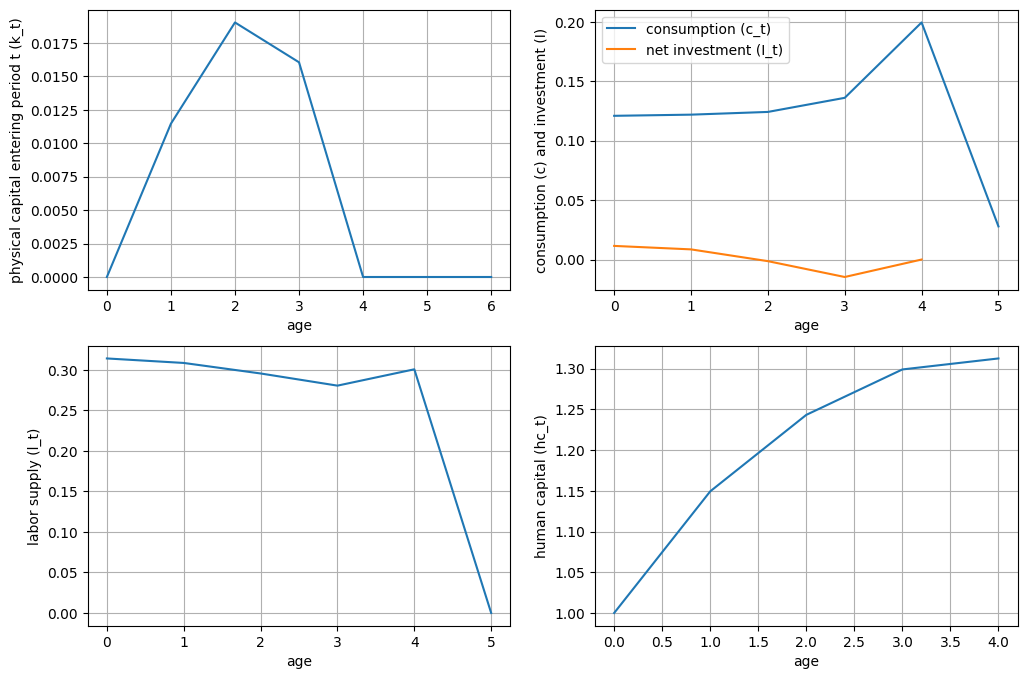

iter: 1; K change: 0.25; H change: 0.07; L change: 0.03; Z change: 0.11
y: 0.4891556248806094
ie: 0.029349337492836563
wage: 0.5162186281598808
tax_revenue: 0.05073562095945108
grants: 0.03424089374164266
T: 0.026277839715420612
iter: 1; K: 0.53; H: 1.86; L: 0.29; Z: 0.11
iter: 1; Y: 0.49; tau: 0.15; T: 0.03
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.0827007497377336
l_gen: 0.4190591486150176
c_gen: 0.07877099537454985
i_gen: 0.08270074973773359
age: 0, ep: 0.048683312596645385, hc: 1.100595460574154
k_gen: 0.0827007497377336
k_gen_next: 0.13882843109913728
l_gen: 0.366731335252092
c_gen: 0.08586628037398321
i_gen: 0.06315724508911104
age: 1, ep: 0.05306837920945871, hc: 1.1694165580587499
k_gen: 0.13882843109913728
k_gen_next: 0.09462229255852952
l_gen: 0.20617662754603222
c_gen: 0.10763636161058189
i_gen: -0.03240572189718113
age: 2, ep: 0.06652286362942901, hc: 1.2375622948237486
k_gen: 0.09462229255852952
k_gen_next: 0.02517163490699064
l_gen: 0.1742113990724545

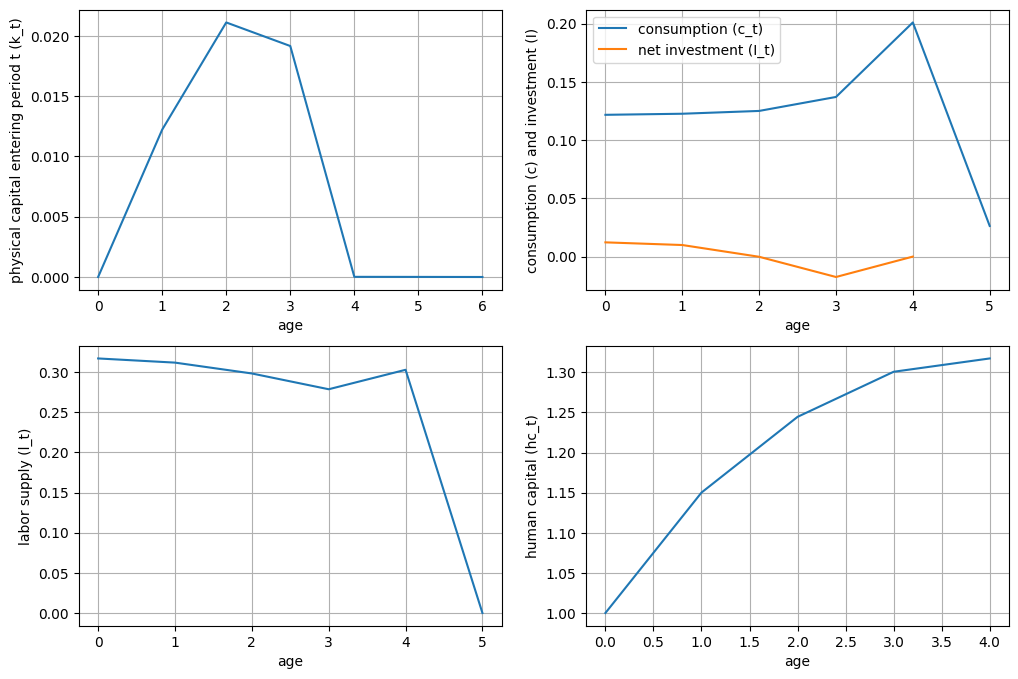

iter: 2; K change: 0.24; H change: 0.06; L change: 0.03; Z change: 0.08
y: 0.4461615755364972
ie: 0.02676969453218983
wage: 0.5137643463873095
tax_revenue: 0.04713745258224158
grants: 0.031231310287554808
T: 0.02482937380541672
iter: 2; K: 0.43; H: 1.75; L: 0.28; Z: 0.12
iter: 2; Y: 0.45; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.08415333500829075
l_gen: 0.42389741655366964
c_gen: 0.07774357882225807
i_gen: 0.08415333500829075
age: 0, ep: 0.048048332253188275, hc: 1.0991646148541114
k_gen: 0.08415333500829075
k_gen_next: 0.14067473133478742
l_gen: 0.36637903600603383
c_gen: 0.08550558589939605
i_gen: 0.06367442980220134
age: 1, ep: 0.05284545478065817, hc: 1.168090556522553
k_gen: 0.14067473133478742
k_gen_next: 0.10032496906978408
l_gen: 0.20819533268323565
c_gen: 0.1068522015397016
i_gen: -0.028392410101546403
age: 2, ep: 0.06603822659272626, hc: 1.2358138870349171
k_gen: 0.10032496906978408
k_gen_next: 0.02994058220446472
l_gen: 0.169697417678

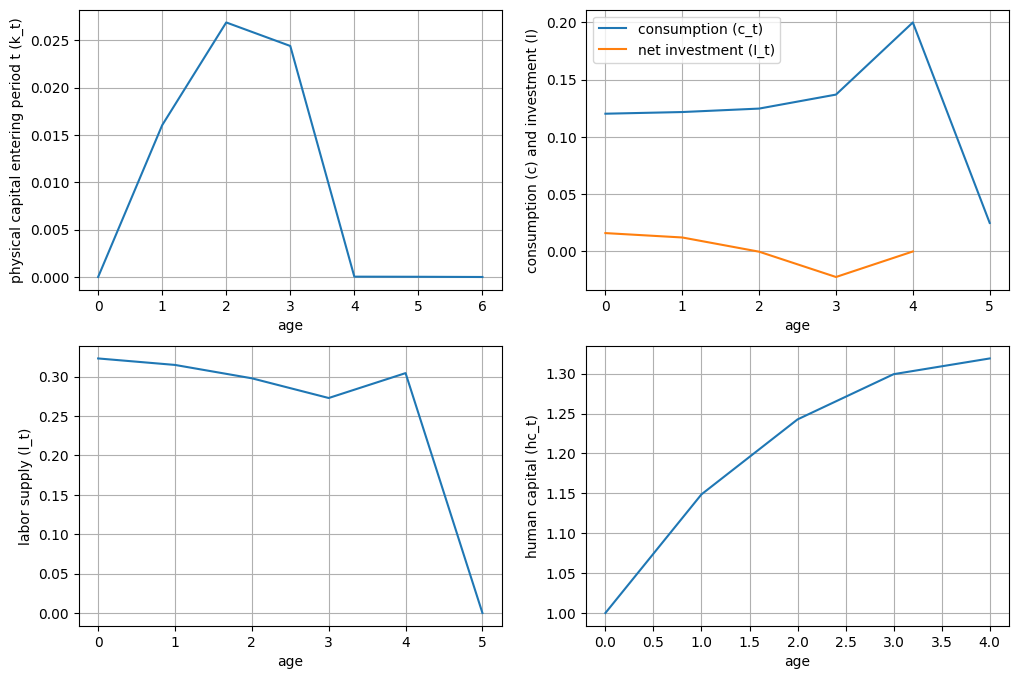

iter: 3; K change: 0.24; H change: 0.05; L change: 0.02; Z change: 0.05
y: 0.4095854775176171
ie: 0.024575128651057026
wage: 0.5070405882395232
tax_revenue: 0.04398831902782874
grants: 0.0286709834262332
T: 0.02350904515194788
iter: 3; K: 0.34; H: 1.67; L: 0.28; Z: 0.13
iter: 3; Y: 0.41; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.08573863730607198
l_gen: 0.42959293146057465
c_gen: 0.07596759334614606
i_gen: 0.08573863730607198
age: 0, ep: 0.04695070927034415, hc: 1.0966553961356496
k_gen: 0.08573863730607198
k_gen_next: 0.14275736174056228
l_gen: 0.36558090515064234
c_gen: 0.08449285176867967
i_gen: 0.06430650860550641
age: 1, ep: 0.05221954642451211, hc: 1.1652125439909278
k_gen: 0.14275736174056228
k_gen_next: 0.10703674662749249
l_gen: 0.20910166301240066
c_gen: 0.10533309443290106
i_gen: -0.023586239365121987
age: 2, ep: 0.06509936772723648, hc: 1.2322418115486822
k_gen: 0.10703674662749249
k_gen_next: 0.03610192943947848
l_gen: 0.162790984866

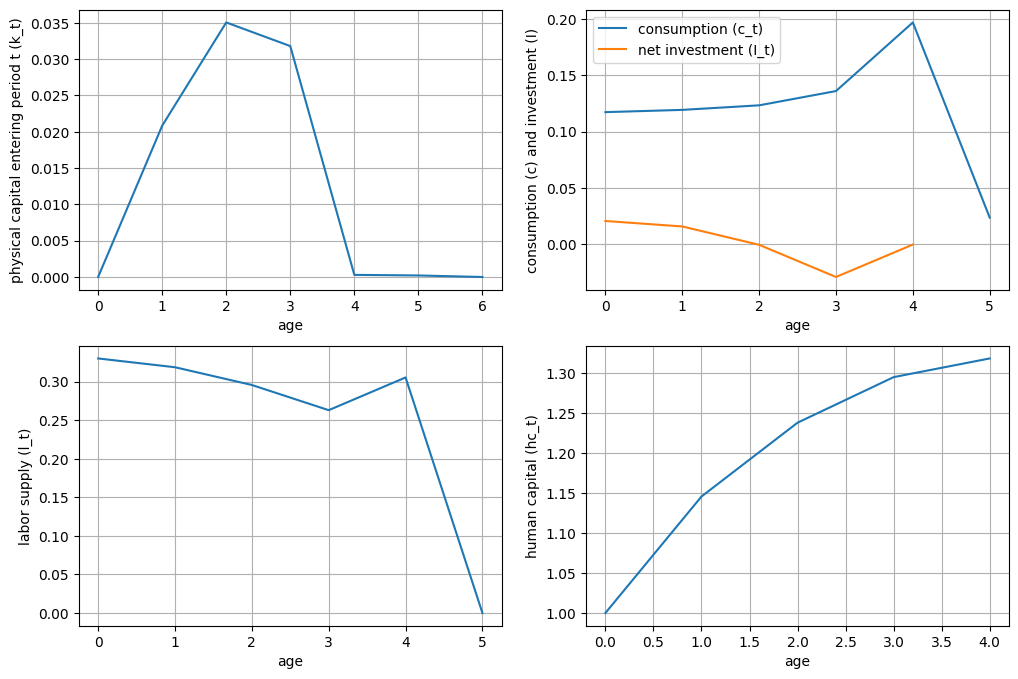

iter: 4; K change: 0.23; H change: 0.04; L change: 0.02; Z change: 0.03
y: 0.3783241816640472
ie: 0.02269945089984283
wage: 0.4974100726591322
tax_revenue: 0.04121656782556552
grants: 0.026482692716483305
T: 0.022300358742363167
iter: 4; K: 0.28; H: 1.60; L: 0.27; Z: 0.13
iter: 4; Y: 0.38; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.0874161276611806
l_gen: 0.43600755349106374
c_gen: 0.07368661510064356
i_gen: 0.08741612766118059
age: 0, ep: 0.045540982513171395, hc: 1.0933634005090132
k_gen: 0.0874161276611806
k_gen_next: 0.14508979198422356
l_gen: 0.36426225049299293
c_gen: 0.08306031693887313
i_gen: 0.06510403517424329
age: 1, ep: 0.051334186135261126, hc: 1.1612699614617517
k_gen: 0.14508979198422356
k_gen_next: 0.11484744281738803
l_gen: 0.2092433086170694
c_gen: 0.10331393569240196
i_gen: -0.017909716848176573
age: 2, ep: 0.06385146021710139, hc: 1.227403668130183
k_gen: 0.11484744281738803
k_gen_next: 0.0446942409052352
l_gen: 0.1549082897534

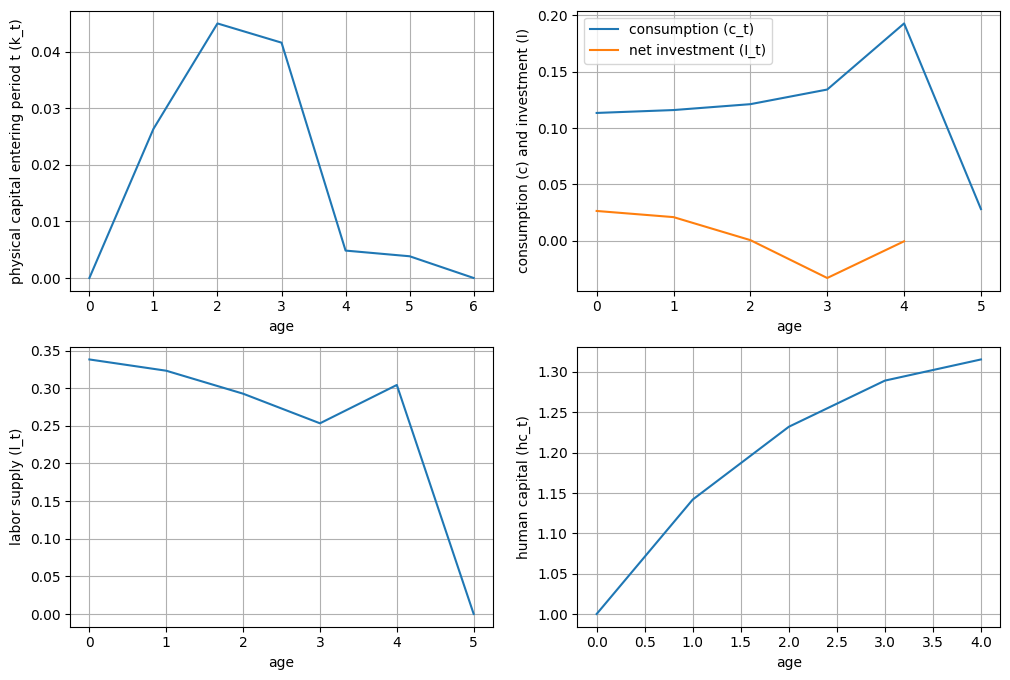

iter: 5; K change: 0.22; H change: 0.04; L change: 0.01; Z change: 0.02
y: 0.35159024948253476
ie: 0.021095414968952085
wage: 0.4861404770741595
tax_revenue: 0.038774316930541286
grants: 0.024611317463777434
T: 0.021194804456414543
iter: 5; K: 0.23; H: 1.54; L: 0.27; Z: 0.14
iter: 5; Y: 0.35; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.08916859416364778
l_gen: 0.4429987052888443
c_gen: 0.07112441897891561
i_gen: 0.0891685941636478
age: 0, ep: 0.043957452956351846, hc: 1.0895677048716985
k_gen: 0.08916859416364778
k_gen_next: 0.14766292255936092
l_gen: 0.36232434820409765
c_gen: 0.081425913285108
i_gen: 0.0660736588996232
age: 1, ep: 0.05032406358751214, hc: 1.1567244885386012
k_gen: 0.14766292255936092
k_gen_next: 0.12361389430145642
l_gen: 0.2086952121073546
c_gen: 0.10104318599426935
i_gen: -0.011497679840358793
age: 2, ep: 0.06244806102203944, hc: 1.221865681692059
k_gen: 0.12361389430145642
k_gen_next: 0.053905975944449416
l_gen: 0.143442516947

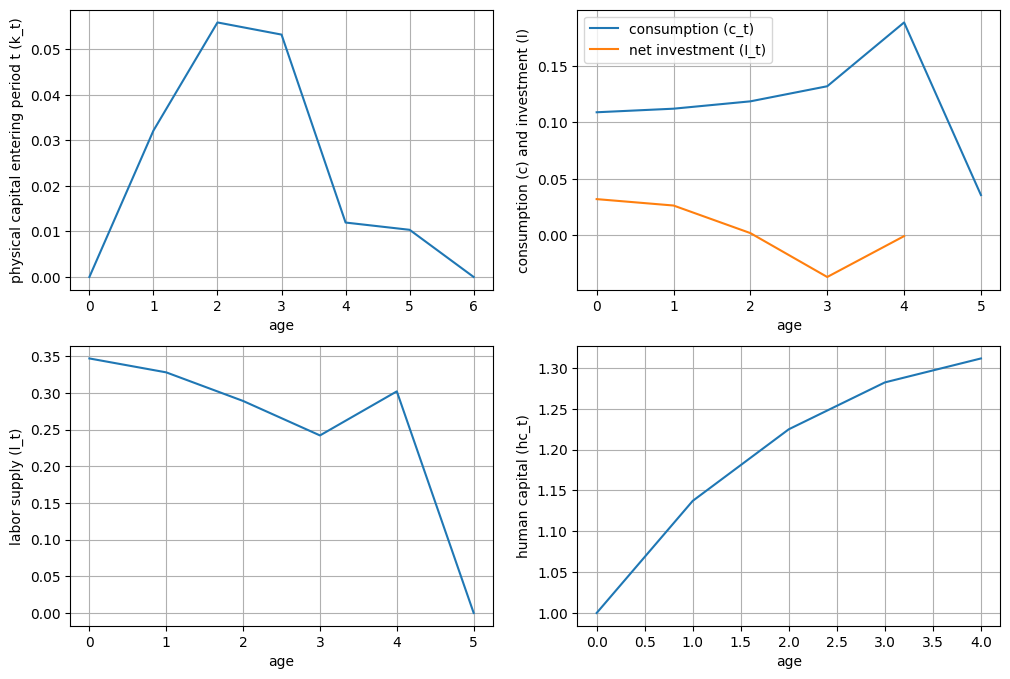

iter: 6; K change: 0.21; H change: 0.03; L change: 0.01; Z change: 0.01
y: 0.32880565032471304
ie: 0.01972833901948278
wage: 0.4743446810492458
tax_revenue: 0.03663147007883465
grants: 0.023016395522729913
T: 0.02019118756259901
iter: 6; K: 0.19; H: 1.49; L: 0.26; Z: 0.14
iter: 6; Y: 0.33; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.09102031831171349
l_gen: 0.45044703067297487
c_gen: 0.06847063225868334
i_gen: 0.09102031831171348
age: 0, ep: 0.042317317122231496, hc: 1.0855204203267792
k_gen: 0.09102031831171349
k_gen_next: 0.1504480893276072
l_gen: 0.3596379405975412
c_gen: 0.0797848921326349
i_gen: 0.06716449807238936
age: 1, ep: 0.04930985101726657, hc: 1.1520000575166975
k_gen: 0.1504480893276072
k_gen_next: 0.13296804108521404
l_gen: 0.20728952513462134
c_gen: 0.09876659640145831
i_gen: -0.004691960649546505
age: 2, ep: 0.06104105247841772, hc: 1.2161820828751821
k_gen: 0.13296804108521404
k_gen_next: 0.06506275043018805
l_gen: 0.1313205511197

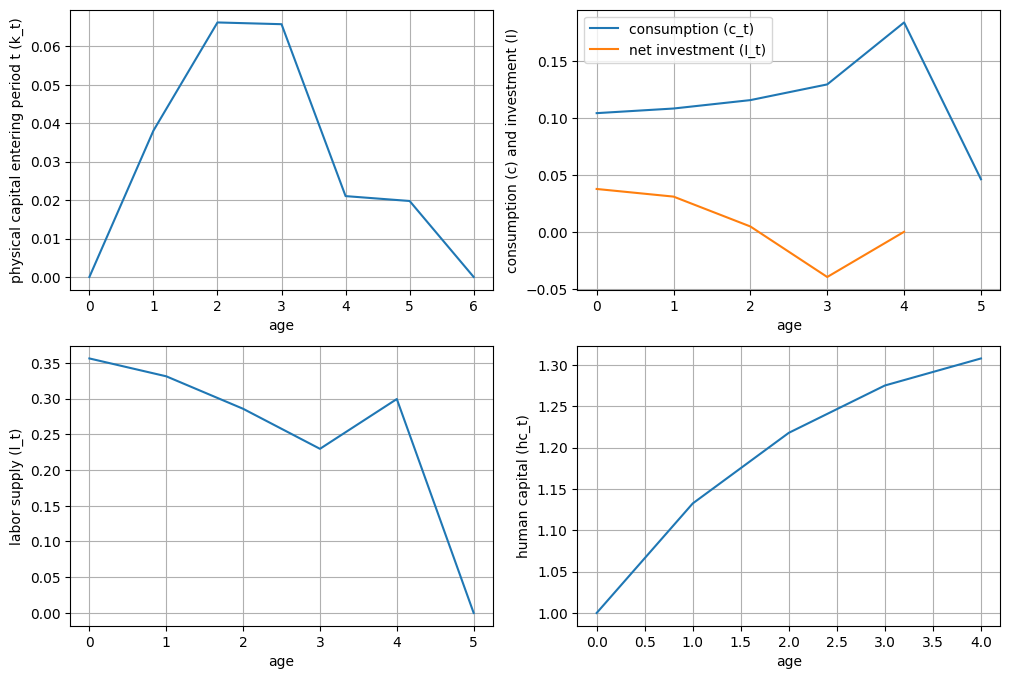

iter: 7; K change: 0.19; H change: 0.03; L change: 0.01; Z change: 0.00
y: 0.30954251395014204
ie: 0.01857255083700852
wage: 0.4629390249171423
tax_revenue: 0.034770232529156814
grants: 0.021667975976509945
T: 0.019293106831649715
iter: 7; K: 0.16; H: 1.46; L: 0.26; Z: 0.14
iter: 7; Y: 0.31; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.09284809948969822
l_gen: 0.4579505879066835
c_gen: 0.06591183683124781
i_gen: 0.0928480994896982
age: 0, ep: 0.04073588934259299, hc: 1.0814988700561554
k_gen: 0.09284809948969822
k_gen_next: 0.15326109103199972
l_gen: 0.3562443164974666
c_gen: 0.07793919798946969
i_gen: 0.06830507999892588
age: 1, ep: 0.04871914408288106, hc: 1.1482979654714285
k_gen: 0.15326109103199972
k_gen_next: 0.1423226817862793
l_gen: 0.2049388638319191
c_gen: 0.09667758074402491
i_gen: 0.002088783491999587
age: 2, ep: 0.05974997078502086, hc: 1.2112843305062073
k_gen: 0.1423226817862793
k_gen_next: 0.07595334068965401
l_gen: 0.116535627935568

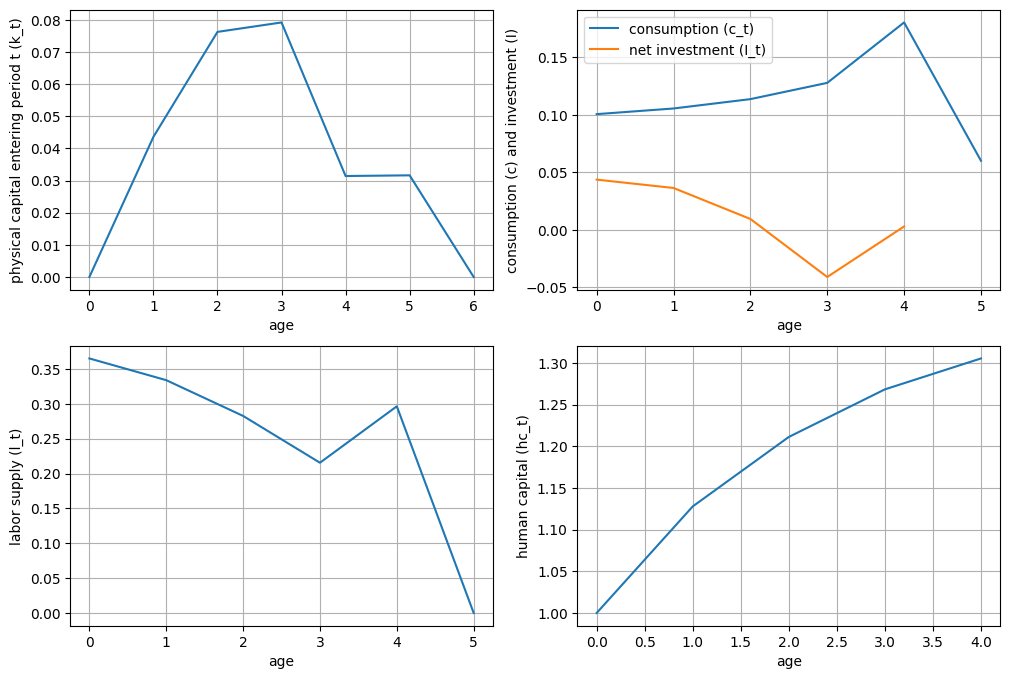

iter: 8; K change: 0.17; H change: 0.02; L change: 0.01; Z change: 0.01
y: 0.2934993202489591
ie: 0.017609959214937545
wage: 0.45267485139509434
tax_revenue: 0.03318175955610496
grants: 0.020544952417427136
T: 0.018506793543657005
iter: 8; K: 0.14; H: 1.43; L: 0.26; Z: 0.14
iter: 8; Y: 0.29; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.09446288312181975
l_gen: 0.4649364109222852
c_gen: 0.0636198913220055
i_gen: 0.09446288312181975
age: 0, ep: 0.03931928671388364, hc: 1.0777905237575822
k_gen: 0.09446288312181975
k_gen_next: 0.15582904038944434
l_gen: 0.3523892457692831
c_gen: 0.0760084565721696
i_gen: 0.06939550233297927
age: 1, ep: 0.04858331174946366, hc: 1.1458739358710053
k_gen: 0.15582904038944434
k_gen_next: 0.15091248742850502
l_gen: 0.2016847368754704
c_gen: 0.09492098974037025
i_gen: 0.00832891547216343
age: 2, ep: 0.05866433857769593, hc: 1.2075211191694475
k_gen: 0.15091248742850502
k_gen_next: 0.0864865922552345
l_gen: 0.1014508118815299

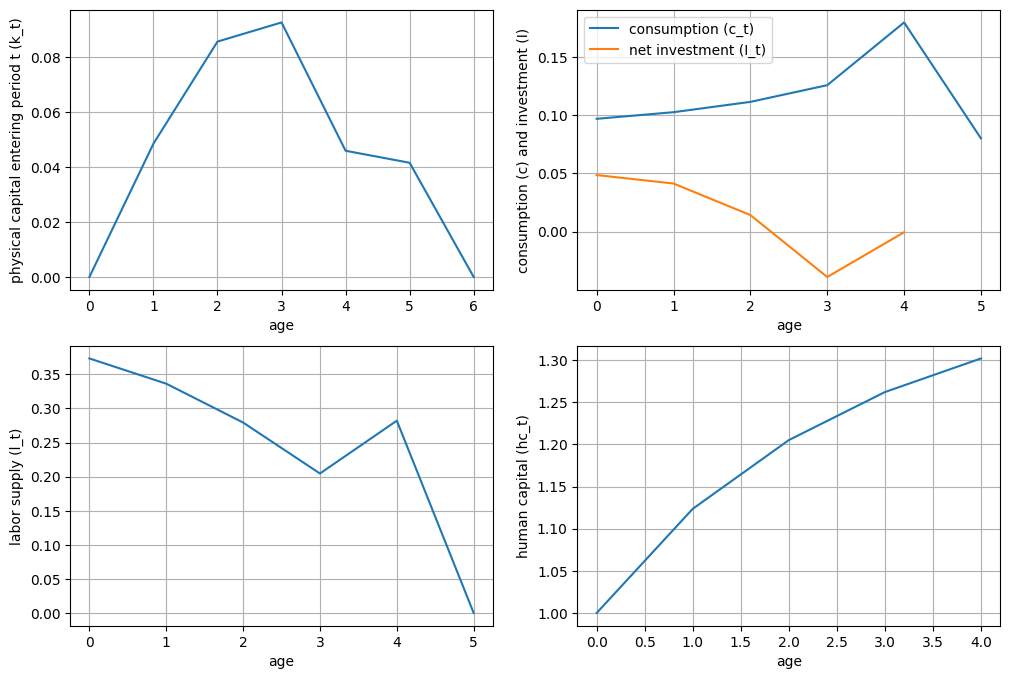

iter: 9; K change: 0.14; H change: 0.02; L change: 0.01; Z change: 0.01
y: 0.2802832877735657
ie: 0.016816997266413943
wage: 0.44445848975918656
tax_revenue: 0.03183964867813719
grants: 0.0196198301441496
T: 0.017825484289458907
iter: 9; K: 0.12; H: 1.40; L: 0.26; Z: 0.13
iter: 9; Y: 0.28; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.06965586134139248
l_gen: 0.4247958142079567
c_gen: 0.06715128812377097
i_gen: 0.06965586134139248
age: 0, ep: 0.04150182495735402, hc: 1.0834617384223681
k_gen: 0.06965586134139248
k_gen_next: 0.14959031654910143
l_gen: 0.39707719493374977
c_gen: 0.06944347822440752
i_gen: 0.08585520342172727
age: 1, ep: 0.044445539512567654, hc: 1.1385826553196063
k_gen: 0.14959031654910143
k_gen_next: 0.15001357154389922
l_gen: 0.2041442692183148
c_gen: 0.09291097382539867
i_gen: 0.013138431901471391
age: 2, ep: 0.057422081546605476, hc: 1.200674230056261
k_gen: 0.15001357154389922
k_gen_next: 0.09075207931725614
l_gen: 0.098542930449

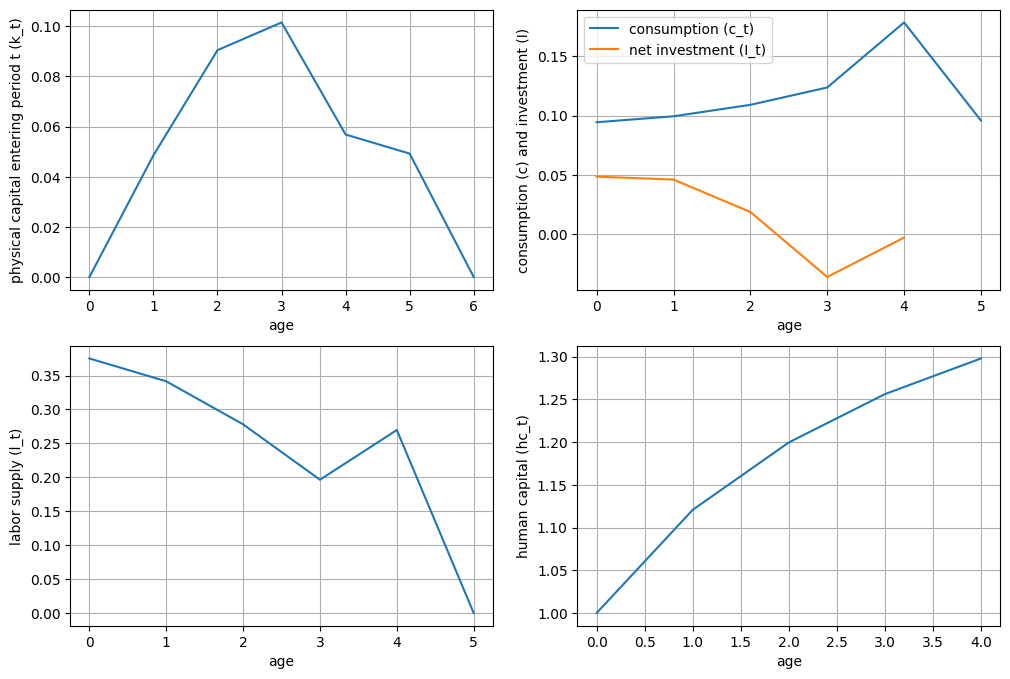

iter: 10; K change: 0.11; H change: 0.02; L change: 0.01; Z change: 0.01
y: 0.2693131091657626
ie: 0.016158786549945757
wage: 0.43789518957377865
tax_revenue: 0.030703622561839027
grants: 0.018851917641603384
T: 0.017237967103550897
iter: 10; K: 0.11; H: 1.38; L: 0.25; Z: 0.13
iter: 10; Y: 0.27; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.03493590970668695
l_gen: 0.36503210424261867
c_gen: 0.0730336462281041
i_gen: 0.03493590970668696
age: 0, ep: 0.04513734328342115, hc: 1.09240594227009
k_gen: 0.03493590970668695
k_gen_next: 0.05950919746602314
l_gen: 0.3211709609418717
c_gen: 0.07807866234128279
i_gen: 0.02754284008440458
age: 1, ep: 0.048255125225998854, hc: 1.1532691806732505
k_gen: 0.05950919746602314
k_gen_next: 0.06779048759728311
l_gen: 0.27419435021540806
c_gen: 0.08348183174315797
i_gen: 0.013339571915871921
age: 2, ep: 0.05159455936445302, hc: 1.194863135715472
k_gen: 0.06779048759728311
k_gen_next: 0.04749158393515335
l_gen: 0.217007060

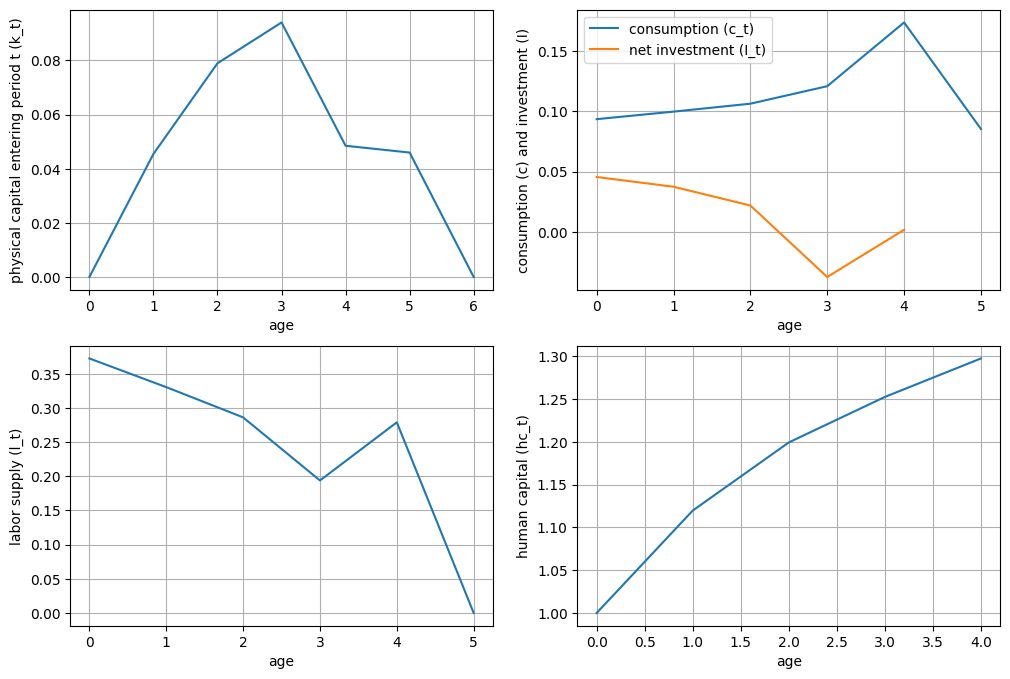

iter: 11; K change: 0.11; H change: 0.01; L change: 0.01; Z change: 0.02
y: 0.25940087830152664
ie: 0.015564052698091599
wage: 0.4304205744300354
tax_revenue: 0.02967675071349429
grants: 0.018158061481106866
T: 0.01670670679841796
iter: 11; K: 0.10; H: 1.36; L: 0.25; Z: 0.13
iter: 11; Y: 0.26; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.037233613957388965
l_gen: 0.3707375281675672
c_gen: 0.07114197158165639
i_gen: 0.03723361395738897
age: 0, ep: 0.04396822212052995, hc: 1.0895938815968298
k_gen: 0.037233613957388965
k_gen_next: 0.06455134424294799
l_gen: 0.32287528401191357
c_gen: 0.0765532199617558
i_gen: 0.030482587471937096
age: 1, ep: 0.04731235395520003, hc: 1.149347477788295
k_gen: 0.06455134424294799
k_gen_next: 0.07545903940659614
l_gen: 0.27111384087672585
c_gen: 0.08240511644074192
i_gen: 0.016394559424298686
age: 2, ep: 0.05092911326343339, hc: 1.1910929565193658
k_gen: 0.07545903940659614
k_gen_next: 0.054007861386944675
l_gen: 0.203421

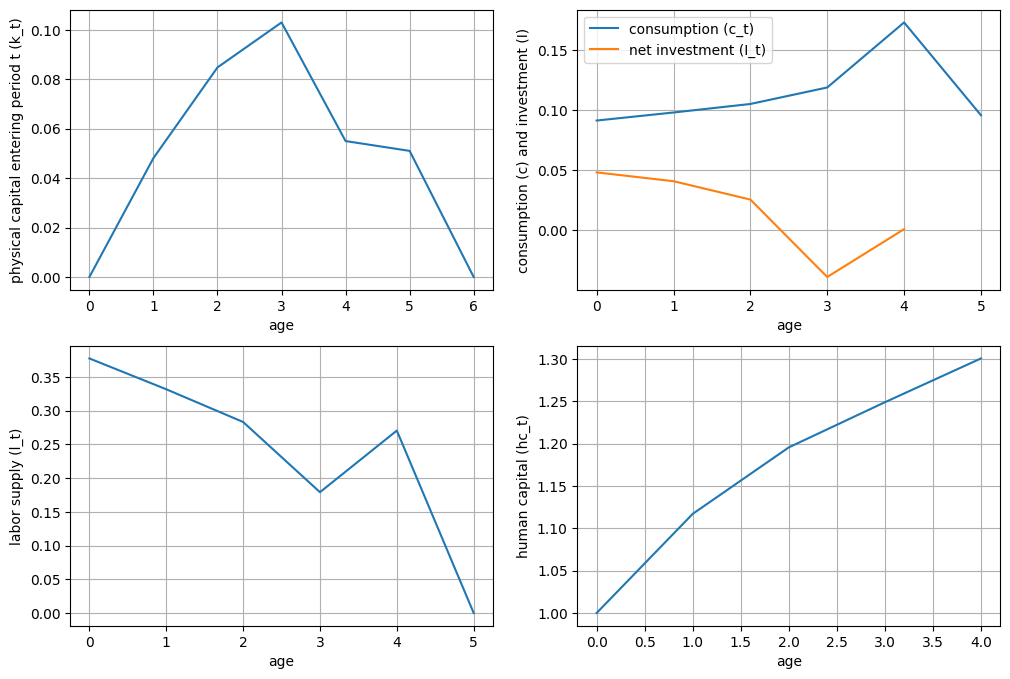

iter: 12; K change: 0.09; H change: 0.01; L change: 0.01; Z change: 0.02
y: 0.2513825937734274
ie: 0.015082955626405645
wage: 0.42492407585821856
tax_revenue: 0.028830335225241338
grants: 0.01759678156413992
T: 0.01626120553656997
iter: 12; K: 0.09; H: 1.35; L: 0.25; Z: 0.13
iter: 12; Y: 0.25; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.038949271913097064
l_gen: 0.3752103717854454
c_gen: 0.06973425932159806
i_gen: 0.03894927191309708
age: 0, ep: 0.04309820671272149, hc: 1.087462573359353
k_gen: 0.038949271913097064
k_gen_next: 0.06846985441806396
l_gen: 0.3242369416826849
c_gen: 0.07542352759509086
i_gen: 0.032831270617580136
age: 1, ep: 0.046614369453117775, hc: 1.1463985884124888
k_gen: 0.06846985441806396
k_gen_next: 0.08170627318651513
l_gen: 0.2687364016736311
c_gen: 0.08161819996399403
i_gen: 0.01905635639398664
age: 2, ep: 0.05044269124523079, hc: 1.1882851857284218
k_gen: 0.08170627318651513
k_gen_next: 0.0598579672497326
l_gen: 0.192569526

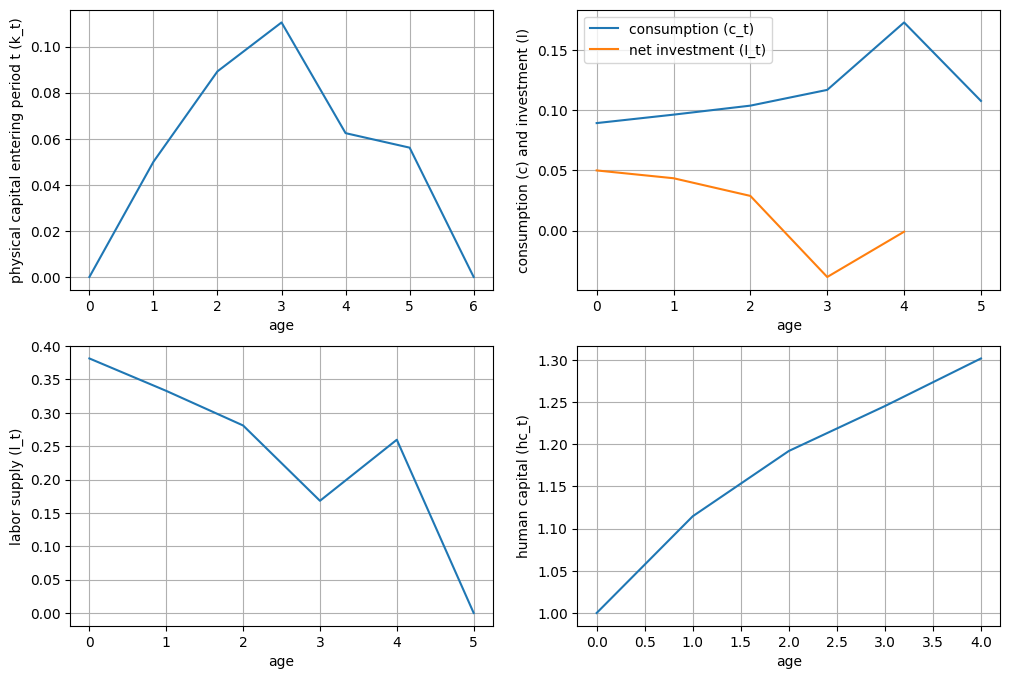

iter: 13; K change: 0.06; H change: 0.01; L change: 0.01; Z change: 0.02
y: 0.24496064921365868
ie: 0.01469763895281952
wage: 0.42131420675685766
tax_revenue: 0.028139469726447045
grants: 0.01714724544495611
T: 0.015891437265764113
iter: 13; K: 0.08; H: 1.34; L: 0.25; Z: 0.13
iter: 13; Y: 0.24; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.040080456267087616
l_gen: 0.37836333541875994
c_gen: 0.06879292381060861
i_gen: 0.040080456267087616
age: 0, ep: 0.042516428436726546, hc: 1.0860183043043463
k_gen: 0.040080456267087616
k_gen_next: 0.07110202766961772
l_gen: 0.32516125649174793
c_gen: 0.07468049200912438
i_gen: 0.03442841018523253
age: 1, ep: 0.04615514670261447, hc: 1.1444265608271216
k_gen: 0.07110202766961772
k_gen_next: 0.0859508415121653
l_gen: 0.2669291340962284
c_gen: 0.08112482589917602
i_gen: 0.02089248619446507
age: 2, ep: 0.05013777150586835, hc: 1.1864553640910502
k_gen: 0.0859508415121653
k_gen_next: 0.0638215810284536
l_gen: 0.1846287

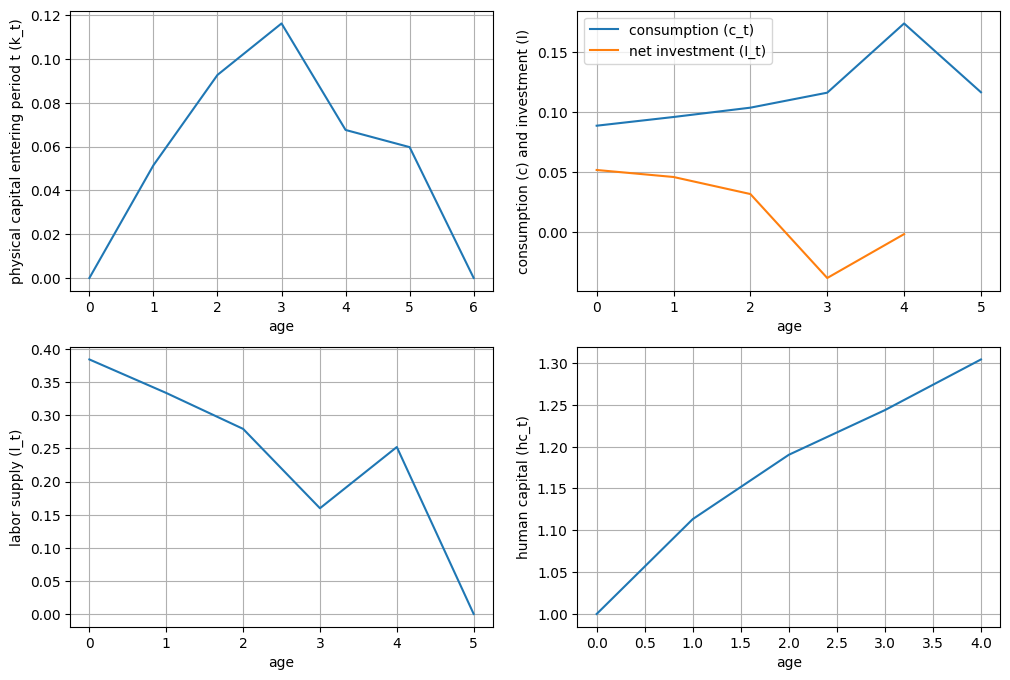

iter: 14; K change: 0.05; H change: 0.01; L change: 0.01; Z change: 0.02
y: 0.23989406529340948
ie: 0.014393643917604568
wage: 0.4190306945825839
tax_revenue: 0.027585928944176906
grants: 0.016792584570538664
T: 0.015591225679506436
iter: 14; K: 0.08; H: 1.33; L: 0.24; Z: 0.12
iter: 14; Y: 0.24; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.04079412636875912
l_gen: 0.38050644305609005
c_gen: 0.06818418810178345
i_gen: 0.04079412636875912
age: 0, ep: 0.042140208466864414, hc: 1.0850759966148116
k_gen: 0.04079412636875912
k_gen_next: 0.07278472585667418
l_gen: 0.3258065905759364
c_gen: 0.0742046976911458
i_gen: 0.03545810022925961
age: 1, ep: 0.0458610886782896, hc: 1.143150483463494
k_gen: 0.07278472585667418
k_gen_next: 0.0887048975842403
l_gen: 0.26575348913456553
c_gen: 0.0808145277291682
i_gen: 0.02210687342538342
age: 2, ep: 0.04994599808401401, hc: 1.1852839164913138
k_gen: 0.0887048975842403
k_gen_next: 0.06638981961690812
l_gen: 0.179270915311

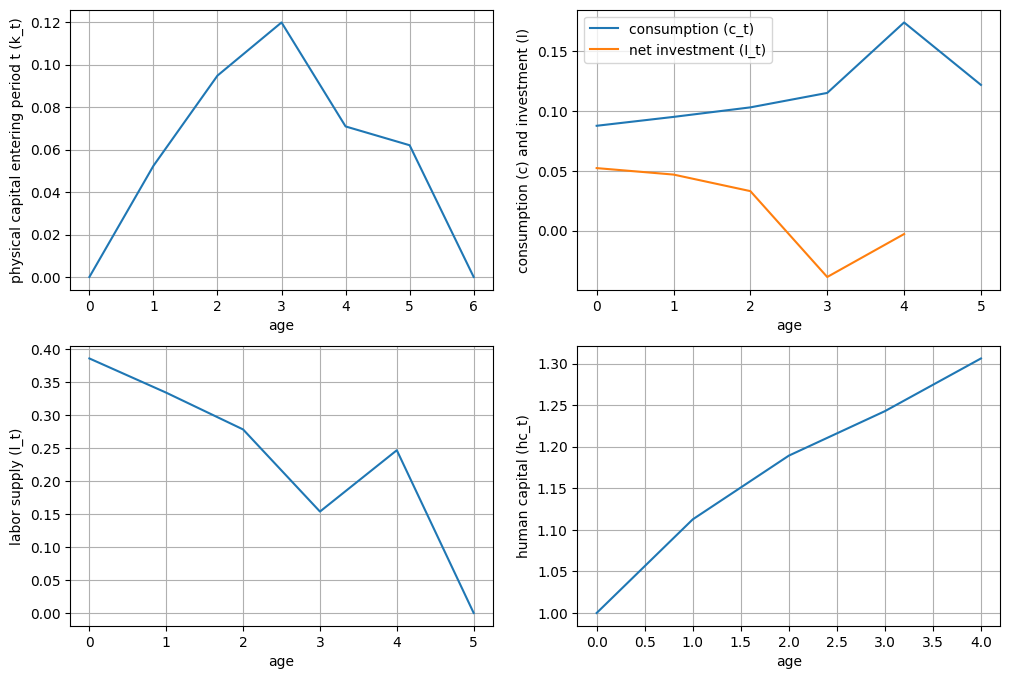

iter: 15; K change: 0.03; H change: 0.00; L change: 0.01; Z change: 0.02
y: 0.23588432009334245
ie: 0.014153059205600546
wage: 0.4176071145985545
tax_revenue: 0.02714219661375638
grants: 0.01651190240653397
T: 0.015347980609089262
iter: 15; K: 0.08; H: 1.33; L: 0.24; Z: 0.12
iter: 15; Y: 0.24; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.04122978309827508
l_gen: 0.38194230627242853
c_gen: 0.06779504432018396
i_gen: 0.041229783098275075
age: 0, ep: 0.041899703986344544, hc: 1.0844701234625453
k_gen: 0.04122978309827508
k_gen_next: 0.07381764161591996
l_gen: 0.32627373368364615
c_gen: 0.07390135989734846
i_gen: 0.03609239008099828
age: 1, ep: 0.04567361499754419, hc: 1.1423326125505462
k_gen: 0.07381764161591996
k_gen_next: 0.09040817244255736
l_gen: 0.26505724740005066
c_gen: 0.0806163460463711
i_gen: 0.022865030363990593
age: 2, ep: 0.04982351593469211, hc: 1.1845336338787202
k_gen: 0.09040817244255736
k_gen_next: 0.06799178993999487
l_gen: 0.175928

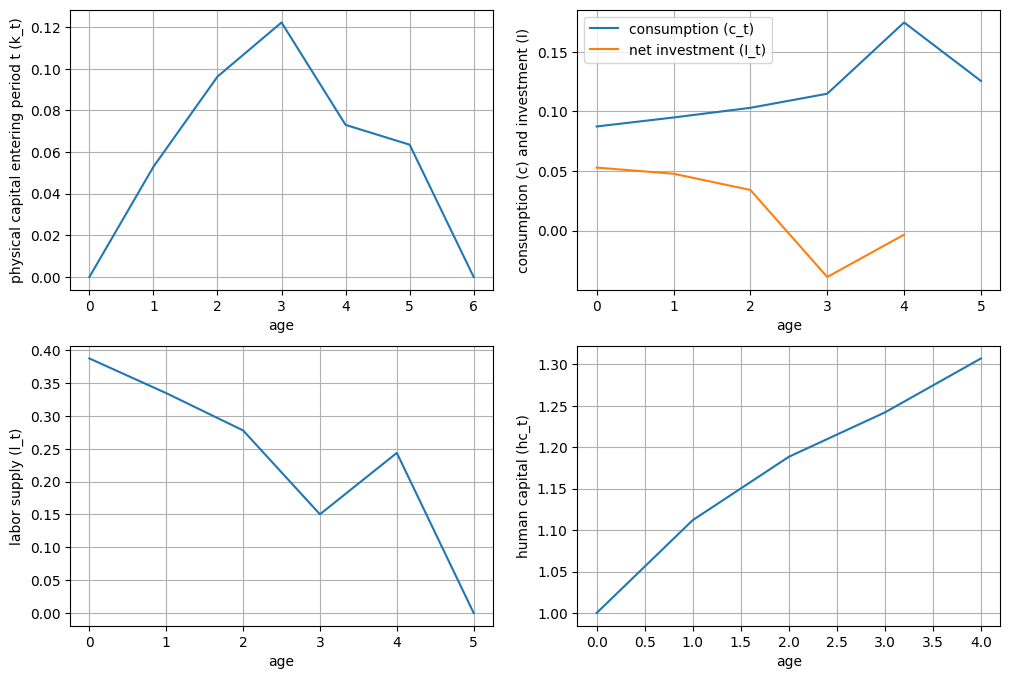

iter: 16; K change: 0.02; H change: 0.00; L change: 0.01; Z change: 0.02
y: 0.2326882196378164
ie: 0.013961293178268984
wage: 0.41669423341970485
tax_revenue: 0.02678480926872852
grants: 0.016288175374647152
T: 0.0151503982868377
iter: 16; K: 0.08; H: 1.32; L: 0.24; Z: 0.12
iter: 16; Y: 0.23; tau: 0.15; T: 0.02
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.04148052315381825
l_gen: 0.3828926424640725
c_gen: 0.06754283070627674
i_gen: 0.041480523153818255
age: 0, ep: 0.04174382714031273, hc: 1.0840759736131989
k_gen: 0.04148052315381825
k_gen_next: 0.07442192564382843
l_gen: 0.3266321587357538
c_gen: 0.07370058319132708
i_gen: 0.03646724695808473
age: 1, ep: 0.04554952778933468, hc: 1.1417944433285474
k_gen: 0.07442192564382843
k_gen_next: 0.09141188013166504
l_gen: 0.26469300670124096
c_gen: 0.08047998651068111
i_gen: 0.023315818167562022
age: 2, ep: 0.04973924164714801, hc: 1.1840303547563165
k_gen: 0.09141188013166504
k_gen_next: 0.06896000319303709
l_gen: 0.173993956

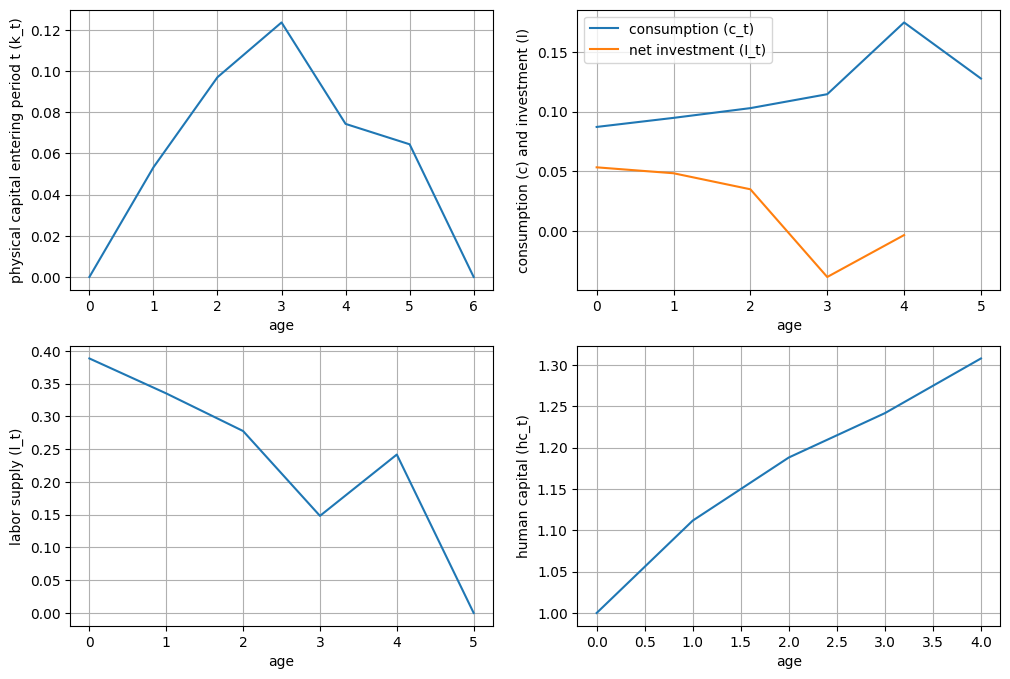

iter: 17; K change: 0.02; H change: 0.00; L change: 0.01; Z change: 0.02
y: 0.23011637129676177
ie: 0.013806982277805706
wage: 0.4160584722707673
tax_revenue: 0.026494854598488705
grants: 0.016108145990773325
T: 0.01498903603365062
iter: 17; K: 0.07; H: 1.32; L: 0.24; Z: 0.12
iter: 17; Y: 0.23; tau: 0.15; T: 0.01
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.04161400903515514
l_gen: 0.3835241914882319
c_gen: 0.06737076086121316
i_gen: 0.041614009035155136
age: 0, ep: 0.04163748194833608, hc: 1.0838064019410532
k_gen: 0.04161400903515514
k_gen_next: 0.0747515409370246
l_gen: 0.3269102187490665
c_gen: 0.07355774895231859
i_gen: 0.036674722669857635
age: 1, ep: 0.04546125113522096, hc: 1.1414172785609125
k_gen: 0.0747515409370246
k_gen_next: 0.09196632841303562
l_gen: 0.2645362986410085
c_gen: 0.08037404144196336
i_gen: 0.023568668455658116
age: 2, ep: 0.0496742177571976, hc: 1.183662368718127
k_gen: 0.09196632841303562
k_gen_next: 0.06952691438033774
l_gen: 0.17297421927

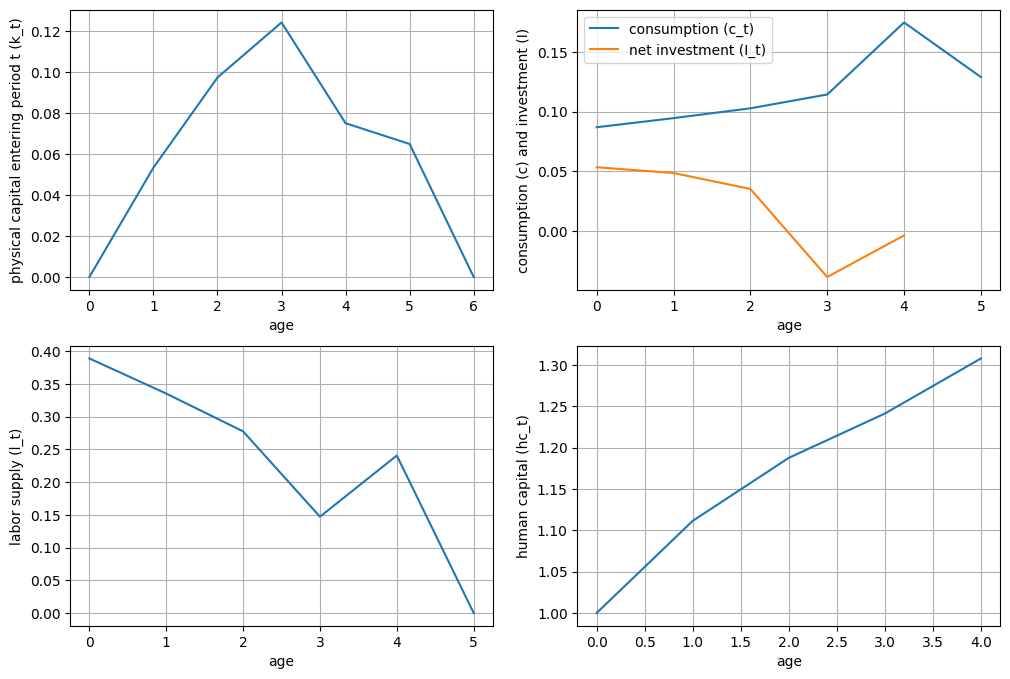

iter: 18; K change: 0.01; H change: 0.00; L change: 0.01; Z change: 0.02
y: 0.22802398506392496
ie: 0.013681439103835498
wage: 0.4155563988943975
tax_revenue: 0.026257466345489894
grants: 0.01596167895447475
T: 0.014856267092293646
iter: 18; K: 0.07; H: 1.32; L: 0.24; Z: 0.12
iter: 18; Y: 0.23; tau: 0.15; T: 0.01
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.04167368136443255
l_gen: 0.38394804207504674
c_gen: 0.06724319797826163
i_gen: 0.04167368136443255
age: 0, ep: 0.041558643617771354, hc: 1.0836062055991467
k_gen: 0.04167368136443255
k_gen_next: 0.07490883514482731
l_gen: 0.327127828719748
c_gen: 0.07344523156577346
i_gen: 0.036777416696371475
age: 1, ep: 0.04539171140995376, hc: 1.1411267244475254
k_gen: 0.07490883514482731
k_gen_next: 0.09224471730393974
l_gen: 0.26450688591834426
c_gen: 0.08027567858490035
i_gen: 0.023703133146422726
age: 2, ep: 0.049620841122344286, hc: 1.1833704516306027
k_gen: 0.09224471730393974
k_gen_next: 0.06984907812345059
l_gen: 0.17250

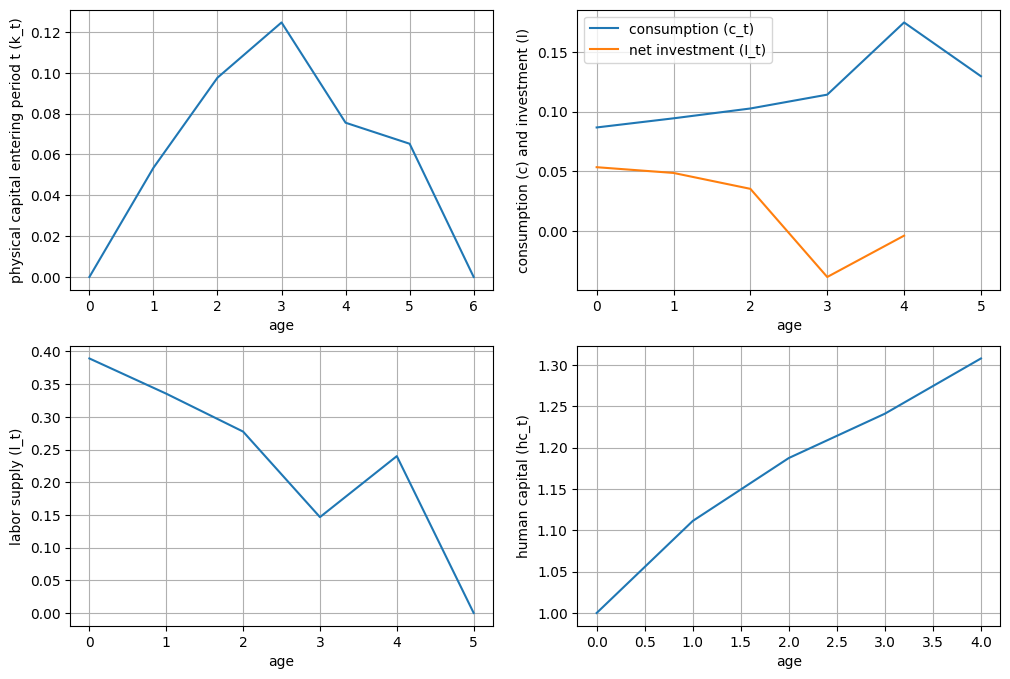

iter: 19; K change: 0.01; H change: 0.00; L change: 0.00; Z change: 0.02
y: 0.2263015760546299
ie: 0.013578094563277793
wage: 0.41510763345607116
tax_revenue: 0.026061138830587458
grants: 0.015841110323824095
T: 0.014746060027855971
iter: 19; K: 0.07; H: 1.32; L: 0.24; Z: 0.11
iter: 19; Y: 0.23; tau: 0.15; T: 0.01
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.04168776073906187
l_gen: 0.38423759033270244
c_gen: 0.06713901048053944
i_gen: 0.041687760739061885
age: 0, ep: 0.0414942520949454, hc: 1.083442471865733
k_gen: 0.04168776073906187
k_gen_next: 0.07496041563916903
l_gen: 0.32729884194308445
c_gen: 0.07334727075161446
i_gen: 0.03681611456292741
age: 1, ep: 0.045331168189655525, hc: 1.140879481505303
k_gen: 0.07496041563916903
k_gen_next: 0.09234884294913162
l_gen: 0.2645319248501721
c_gen: 0.08018305575930167
i_gen: 0.023760062639291965
age: 2, ep: 0.049568769407821525, hc: 1.1831050623785424
k_gen: 0.09234884294913162
k_gen_next: 0.07002122988511157
l_gen: 0.172373

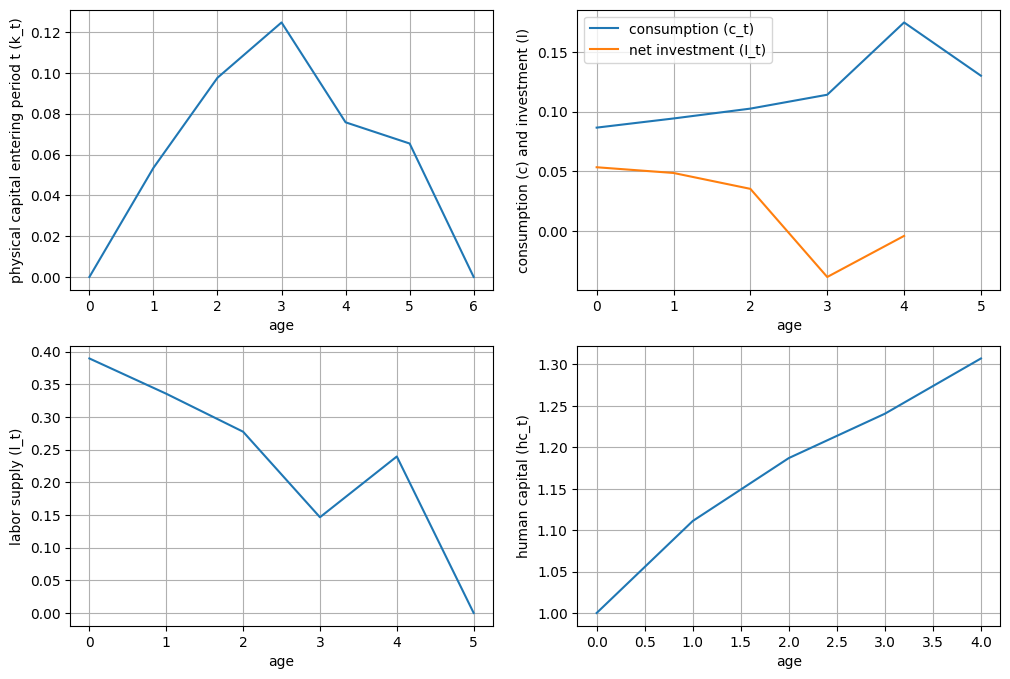

iter: 20; K change: 0.01; H change: 0.00; L change: 0.00; Z change: 0.02
y: 0.2248664333430311
ie: 0.013491986000581865
wage: 0.4146718127394129
tax_revenue: 0.025897009100511494
grants: 0.015740650334012177
T: 0.014653687433359944
iter: 20; K: 0.07; H: 1.31; L: 0.24; Z: 0.11
iter: 20; Y: 0.22; tau: 0.15; T: 0.01
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.04167431828332884
l_gen: 0.38444037990838537
c_gen: 0.06704643363173839
i_gen: 0.041674318283328834
age: 0, ep: 0.04143703636110564, hc: 1.0832968162340941
k_gen: 0.04167431828332884
k_gen_next: 0.07494870301099993
l_gen: 0.32743350641371477
c_gen: 0.07325559600815582
i_gen: 0.03681670178175403
age: 1, ep: 0.04527451000221081, hc: 1.140652186043852
k_gen: 0.07494870301099993
k_gen_next: 0.09234942455788225
l_gen: 0.26457879528041867
c_gen: 0.08009123881045113
i_gen: 0.02377136130281733
age: 2, ep: 0.04951609992697928, hc: 1.1828487996309351
k_gen: 0.09234942455788225
k_gen_next: 0.07010522718607455
l_gen: 0.1724251

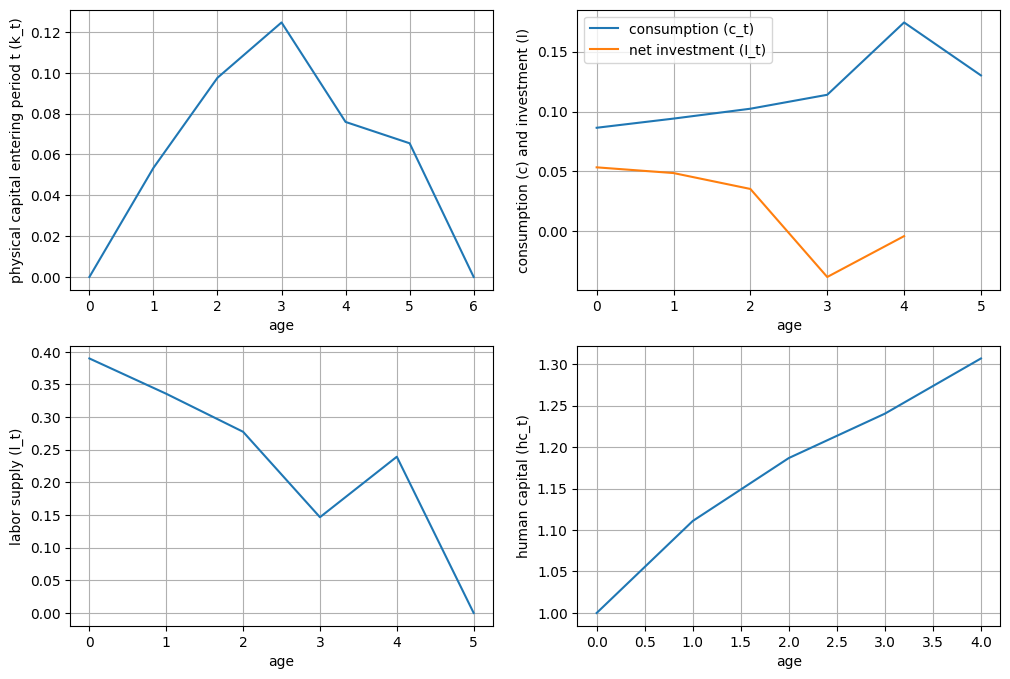

iter: 21; K change: 0.01; H change: 0.00; L change: 0.00; Z change: 0.02
y: 0.22365620455943722
ie: 0.013419372273566233
wage: 0.41423232452716197
tax_revenue: 0.025758286380259884
grants: 0.015655934319160607
T: 0.014575476152288032
iter: 21; K: 0.07; H: 1.31; L: 0.23; Z: 0.11
iter: 21; Y: 0.22; tau: 0.15; T: 0.01
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.04164482684826447
l_gen: 0.3845868498598297
c_gen: 0.0669594382273566
i_gen: 0.04164482684826448
age: 0, ep: 0.041383270156680446, hc: 1.0831597974050178
k_gen: 0.04164482684826447
k_gen_next: 0.07490038407527023
l_gen: 0.32753982792342556
c_gen: 0.07316638814949963
i_gen: 0.036795367509108265
age: 1, ep: 0.0452193764487666, hc: 1.1404335134682395
k_gen: 0.07490038407527023
k_gen_next: 0.09229066157228125
l_gen: 0.26462975230464114
c_gen: 0.07999859273733037
i_gen: 0.023756810143408982
age: 2, ep: 0.04946241127632906, hc: 1.1825944970492188
k_gen: 0.09229066157228125
k_gen_next: 0.07013881957796225
l_gen: 0.17257

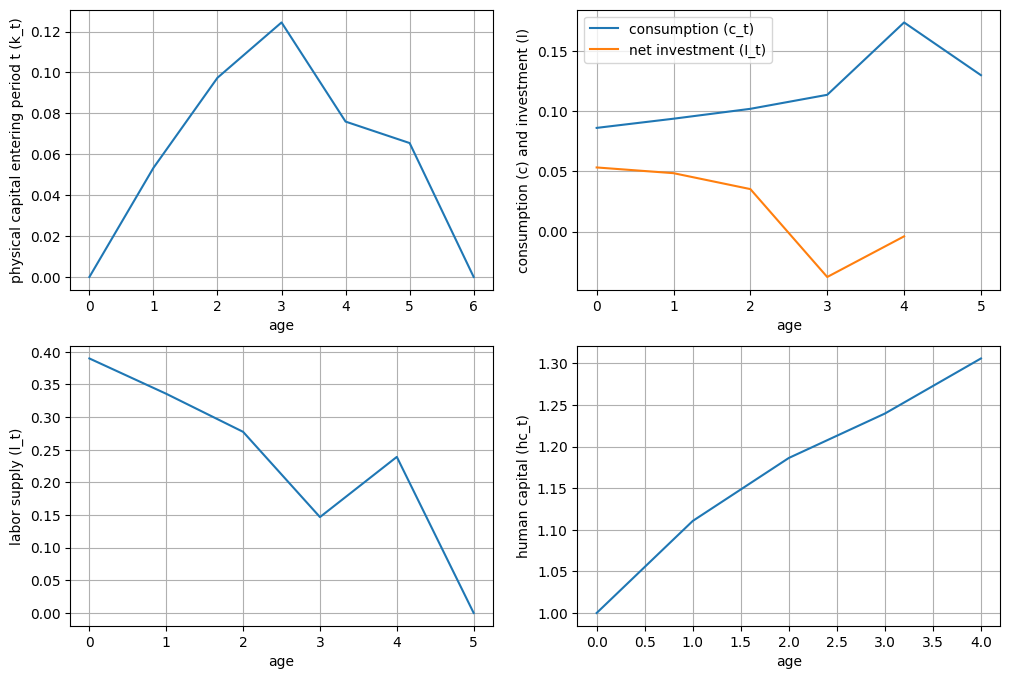

iter: 22; K change: 0.01; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.222623769942511
ie: 0.01335742619655066
wage: 0.41378548142524096
tax_revenue: 0.025639769680285432
grants: 0.015583663895975772
T: 0.014508581183159883
iter: 22; K: 0.07; H: 1.31; L: 0.23; Z: 0.11
iter: 22; Y: 0.22; tau: 0.15; T: 0.01
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.04160650915824156
l_gen: 0.3846963651390811
c_gen: 0.06687530450544976
i_gen: 0.04160650915824157
age: 0, ep: 0.04133127257334128, hc: 1.0830271520462544
k_gen: 0.04160650915824156
k_gen_next: 0.07483204242834678
l_gen: 0.3276241021440687
c_gen: 0.07307830218156203
i_gen: 0.03676208654855577
age: 1, ep: 0.04516493627048214, hc: 1.140218954187452
k_gen: 0.07483204242834678
k_gen_next: 0.09219973457380991
l_gen: 0.2646761057393383
c_gen: 0.07990516541989082
i_gen: 0.023728415751872622
age: 2, ep: 0.04940803400591478, hc: 1.1823405669658786
k_gen: 0.09219973457380991
k_gen_next: 0.07014465250175426
l_gen: 0.17275947156

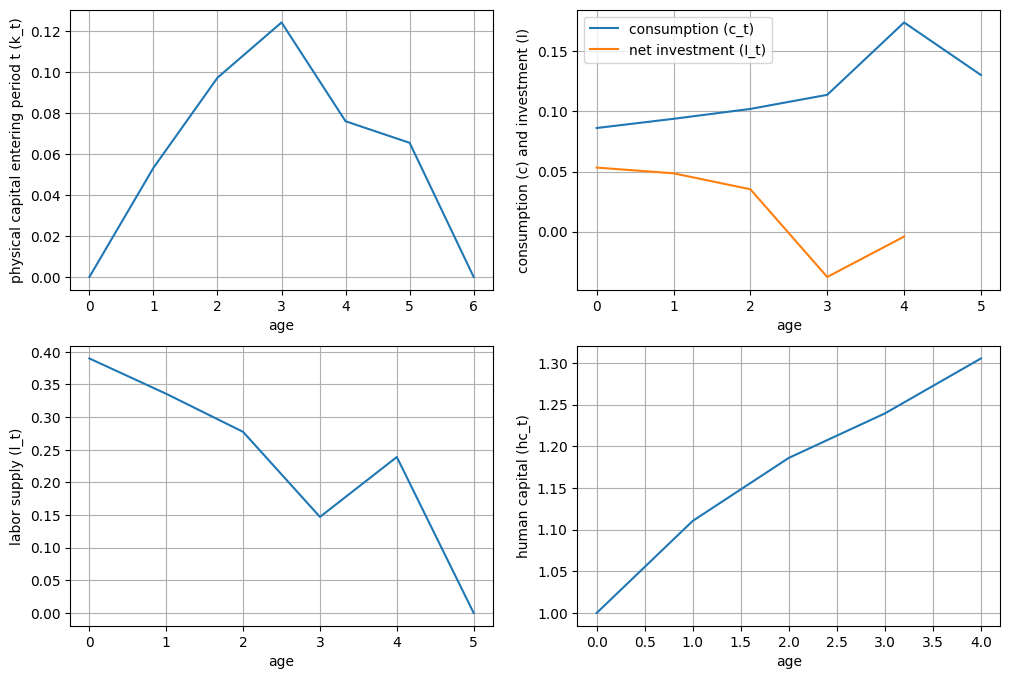

iter: 23; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.2217333767820168
ie: 0.013304002606921007
wage: 0.4133338826842835
tax_revenue: 0.02553746937730432
grants: 0.015521336374741177
T: 0.014450800538203483
iter: 23; K: 0.07; H: 1.31; L: 0.23; Z: 0.11
iter: 23; Y: 0.22; tau: 0.15; T: 0.01
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.04156387952447273
l_gen: 0.38478123267110365
c_gen: 0.066793103986898
i_gen: 0.04156387952447271
age: 0, ep: 0.04128046977822593, hc: 1.0828974273179457
k_gen: 0.04156387952447273
k_gen_next: 0.07475387618493663
l_gen: 0.32769126663977277
c_gen: 0.07299125377910981
i_gen: 0.03672292642004405
age: 1, ep: 0.04511113734788277, hc: 1.1400075711566506
k_gen: 0.07475387618493663
k_gen_next: 0.09209312949519802
l_gen: 0.2647143540557266
c_gen: 0.07981175511539199
i_gen: 0.02369333278598098
age: 2, ep: 0.04935359502567938, hc: 1.1820881008368258
k_gen: 0.09209312949519802
k_gen_next: 0.0701358366202334
l_gen: 0.172960387494

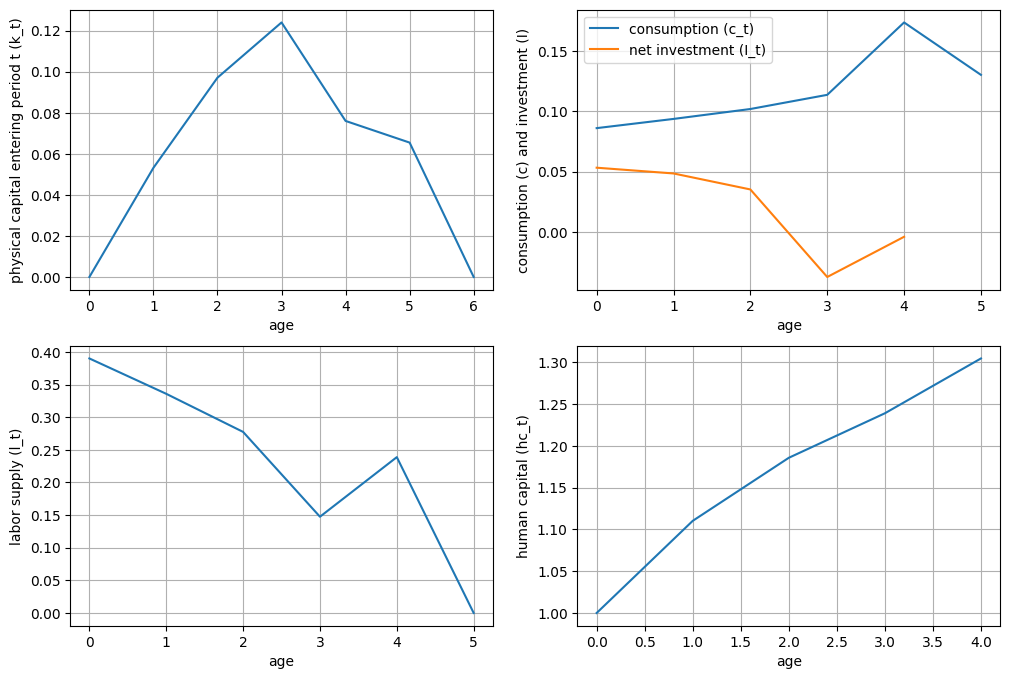

iter: 24; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.22095777359372223
ie: 0.013257466415623333
wage: 0.412882583502054
tax_revenue: 0.025448317724042012
grants: 0.015467044151560558
T: 0.014400429044355907
iter: 24; K: 0.07; H: 1.31; L: 0.23; Z: 0.11
iter: 24; Y: 0.22; tau: 0.15; T: 0.01
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.04151973896637012
l_gen: 0.3848493038478716
c_gen: 0.06671279355898926
i_gen: 0.04151973896637013
age: 0, ep: 0.04123083512592127, hc: 1.08277056369838
k_gen: 0.04151973896637012
k_gen_next: 0.07467209014420338
l_gen: 0.32774516728523223
c_gen: 0.07290571266187057
i_gen: 0.03668152898997476
age: 1, ep: 0.045058269981910544, hc: 1.1398000881901582
k_gen: 0.07467209014420338
k_gen_next: 0.0919807040050038
l_gen: 0.26474376867209004
c_gen: 0.07971938813482701
i_gen: 0.023655741523057702
age: 2, ep: 0.04929977110399978, hc: 1.1818392145461771
k_gen: 0.0919807040050038
k_gen_next: 0.07012002525892017
l_gen: 0.1731583499

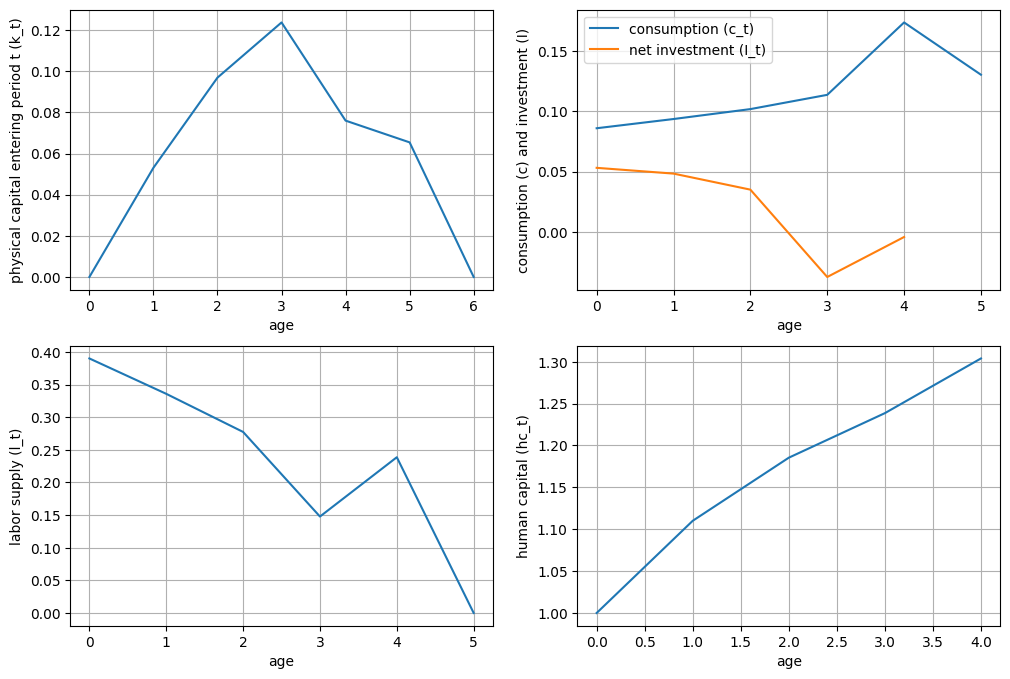

iter: 25; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.2202760479216443
ie: 0.013216562875298658
wage: 0.4124370688179094
tax_revenue: 0.02536994407170085
grants: 0.015419323354515102
T: 0.014356141675618633
iter: 25; K: 0.07; H: 1.31; L: 0.23; Z: 0.10
iter: 25; Y: 0.22; tau: 0.15; T: 0.01
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.041475800844714444
l_gen: 0.3849056155675684
c_gen: 0.0666347077452479
i_gen: 0.041475800844714444
age: 0, ep: 0.04118257536346113, hc: 1.0826470986155214
k_gen: 0.041475800844714444
k_gen_next: 0.07459039988957639
l_gen: 0.3277887899626638
c_gen: 0.0728223190905029
i_gen: 0.03664004211666266
age: 1, ep: 0.04500672987459116, hc: 1.1395978360013772
k_gen: 0.07459039988957639
k_gen_next: 0.09186824105206223
l_gen: 0.2647649899068814
c_gen: 0.0796290526313847
i_gen: 0.02361802515309985
age: 2, ep: 0.049247170662037855, hc: 1.181596180107977
k_gen: 0.09186824105206223
k_gen_next: 0.07010143472227115
l_gen: 0.17334557175

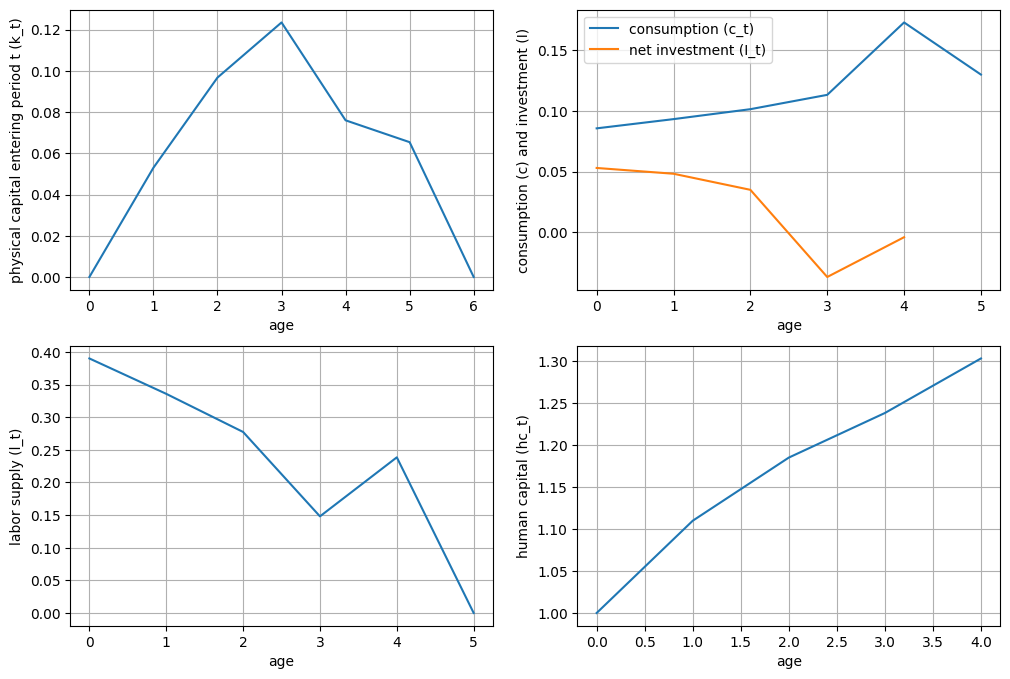

iter: 26; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.2196720588601709
ie: 0.013180323531610255
wage: 0.41200223635915506
tax_revenue: 0.025300508767816133
grants: 0.015377044120211965
T: 0.01431690582480759
iter: 26; K: 0.07; H: 1.31; L: 0.23; Z: 0.10
iter: 26; Y: 0.22; tau: 0.15; T: 0.01
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.041433042744578055
l_gen: 0.38495334043909046
c_gen: 0.06655929006232783
i_gen: 0.04143304274457804
age: 0, ep: 0.041135964599509287, hc: 1.0825277438067757
k_gen: 0.041433042744578055
k_gen_next: 0.07451088572352849
l_gen: 0.32782440061542817
c_gen: 0.0727416887706292
i_gen: 0.03659965161223955
age: 1, ep: 0.044956897552682916, hc: 1.1394022053194404
k_gen: 0.07451088572352849
k_gen_next: 0.09175890603406445
l_gen: 0.2647792260766255
c_gen: 0.07954153059467478
i_gen: 0.023581445597035865
age: 2, ep: 0.0491963257118343, hc: 1.181361110303228
k_gen: 0.09175890603406445
k_gen_next: 0.07008224279811996
l_gen: 0.173518

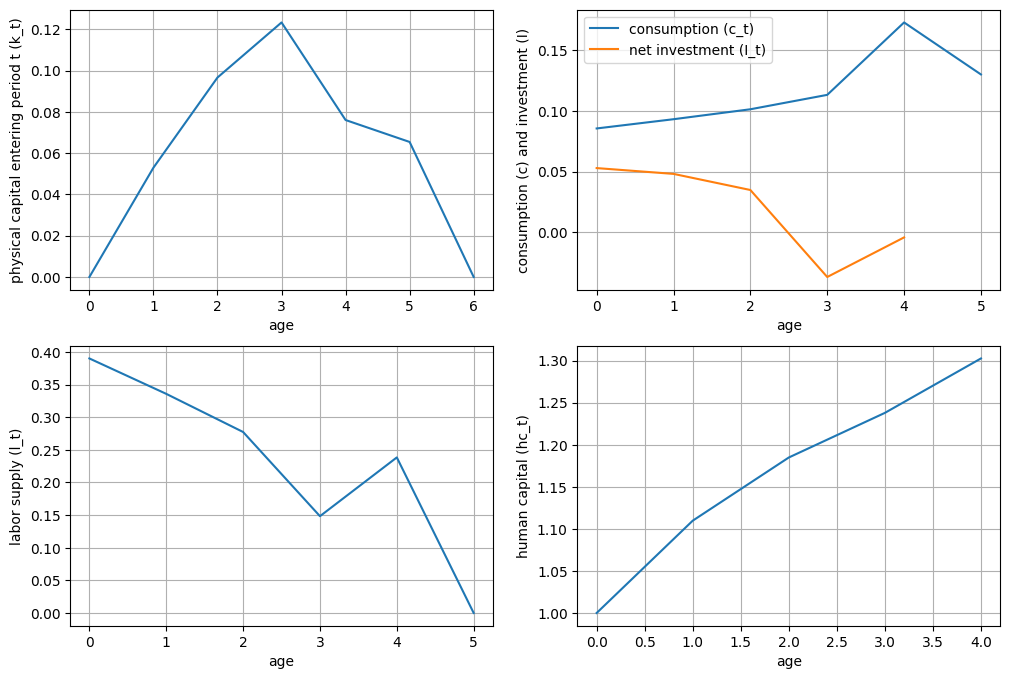

iter: 27; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.21913321678942094
ie: 0.013147993007365256
wage: 0.4115820445597522
tax_revenue: 0.025238570893865234
grants: 0.015339325175259468
T: 0.014281910054394187
iter: 27; K: 0.07; H: 1.31; L: 0.23; Z: 0.10
iter: 27; Y: 0.22; tau: 0.15; T: 0.01
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.0413921593936457
l_gen: 0.38499482085274234
c_gen: 0.06648692338290663
i_gen: 0.041392159393645704
age: 0, ep: 0.04109123946260602, hc: 1.082413117102004
k_gen: 0.0413921593936457
k_gen_next: 0.07443495038620279
l_gen: 0.327853824843919
c_gen: 0.07266432015446087
i_gen: 0.036561124541016954
age: 1, ep: 0.04490908107638591, hc: 1.1392143488619524
k_gen: 0.07443495038620279
k_gen_next: 0.09165474211636412
l_gen: 0.26478775881833577
c_gen: 0.07945754716713228
i_gen: 0.02354676251298855
age: 2, ep: 0.04914751973250321, hc: 1.181135357436511
k_gen: 0.09165474211636412
k_gen_next: 0.07006385491874444
l_gen: 0.1736773593

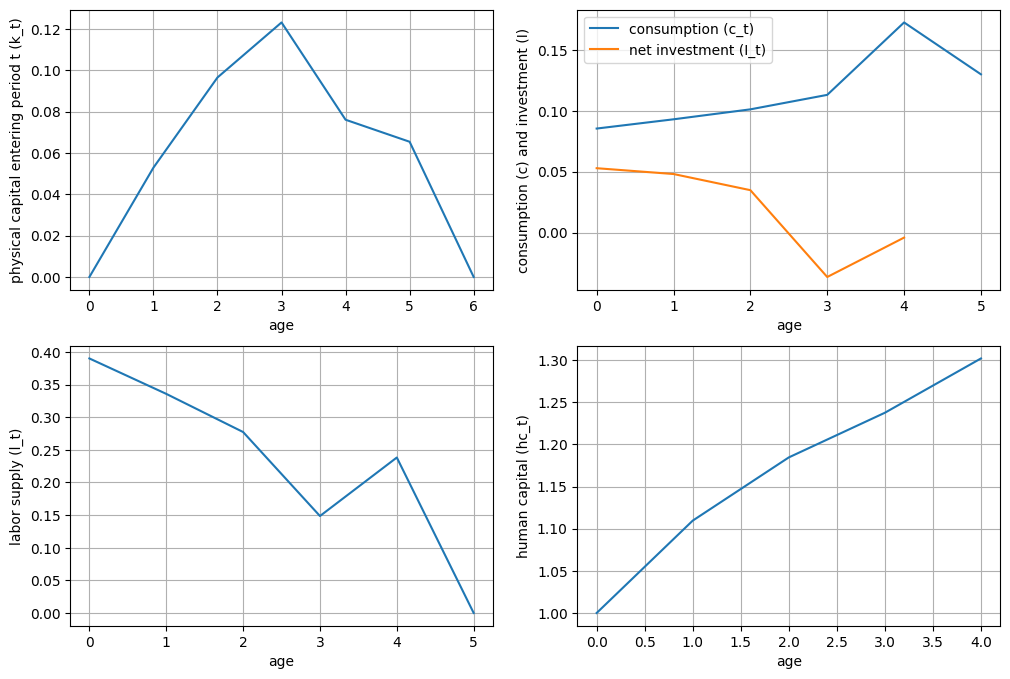

iter: 28; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.21864964398358372
ie: 0.013118978639015023
wage: 0.4111794107023668
tax_revenue: 0.025182996405898158
grants: 0.015305475078850862
T: 0.014250514206718969
iter: 28; K: 0.07; H: 1.31; L: 0.23; Z: 0.10
iter: 28; Y: 0.22; tau: 0.15; T: 0.01
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.041353418512769635
l_gen: 0.3850313982037797
c_gen: 0.06641793151786257
i_gen: 0.041353418512769635
age: 0, ep: 0.04104860007912444, hc: 1.0823037443075563
k_gen: 0.041353418512769635
k_gen_next: 0.07436313065011638
l_gen: 0.3278783872963172
c_gen: 0.07259058281441103
i_gen: 0.03652475271093218
age: 1, ep: 0.04486350885411445, hc: 1.139035162796118
k_gen: 0.07436313065011638
k_gen_next: 0.09155649993021091
l_gen: 0.264791863244853
c_gen: 0.07937749799106303
i_gen: 0.02351423538535441
age: 2, ep: 0.04910104258512771, hc: 1.180920153579704
k_gen: 0.09155649993021091
k_gen_next: 0.07004667897049215
l_gen: 0.173821341

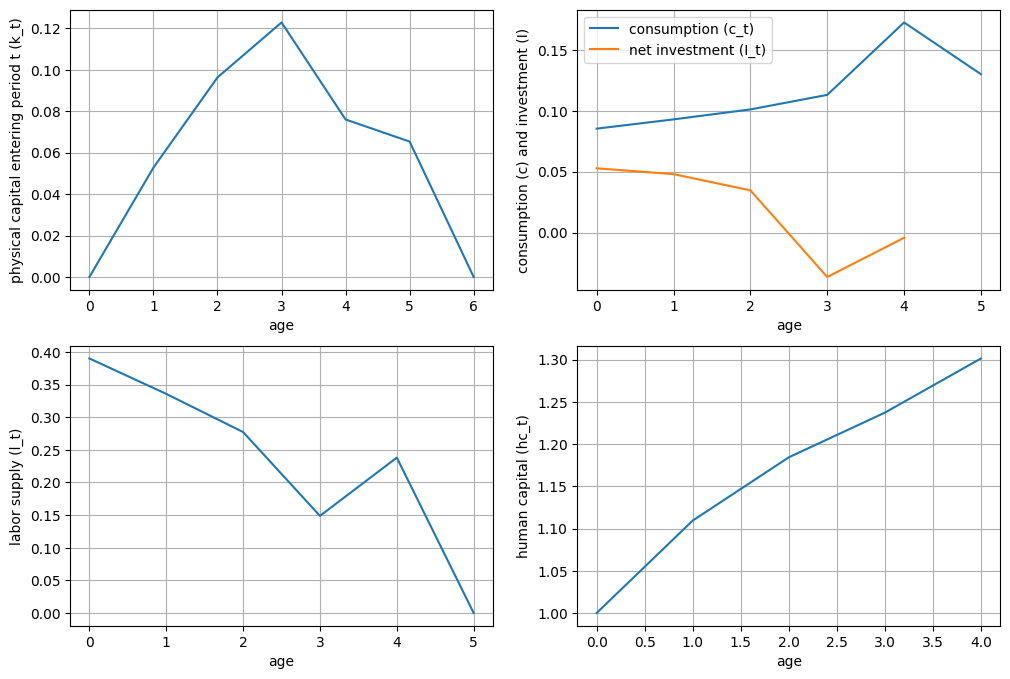

iter: 29; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.2182134846294112
ie: 0.013092809077764672
wage: 0.4107963099222263
tax_revenue: 0.02513288141187512
grants: 0.015274943924058785
T: 0.014222207180404562
iter: 29; K: 0.07; H: 1.30; L: 0.23; Z: 0.10
iter: 29; Y: 0.22; tau: 0.15; T: 0.01
Got to checkpoint
Got to checkpoint 2
k_gen: 0.0
k_gen_next: 0.04131696952490957
l_gen: 0.3850640657727593
c_gen: 0.06635252425681215
i_gen: 0.04131696952490956
age: 0, ep: 0.04100817610631697, hc: 1.082199971383359
k_gen: 0.04131696952490957
k_gen_next: 0.07429569974542781
l_gen: 0.32789912207576344
c_gen: 0.07252071197172757
i_gen: 0.03649067263013554
age: 1, ep: 0.04482032626064757, hc: 1.1388652284089222
k_gen: 0.07429569974542781
k_gen_next: 0.09146451806643414
l_gen: 0.26479261545029015
c_gen: 0.07930165868352121
i_gen: 0.0234839527993677
age: 2, ep: 0.04905704557173037, hc: 1.180716208024417
k_gen: 0.09146451806643414
k_gen_next: 0.07003092947553977
l_gen: 0.173951916793

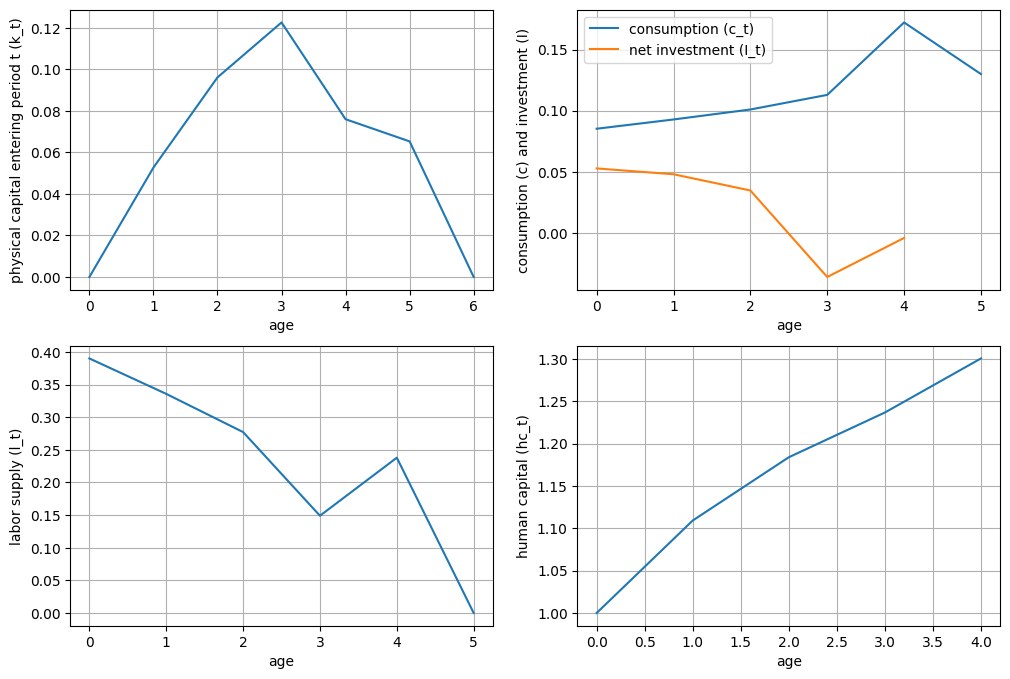

In [298]:
hc_min = np.ones(child_periods+1)
hc_max = np.ones(child_periods+1)
e_mean = 0.15 * np.ones(child_periods+1)
e_minprop = 0.001
e_maxprop = 1
deggridh = 2.5
deggridk = 3.0

hc_grid = np.zeros((nh, child_periods + 1))


iteration = -1
K_diff = 1 + tolerance
state_var_iter_array = np.zeros((max_iters,4))

omega = 0.1


v_optimal_array = np.zeros((na, nh, periods + 1)) #vw initialize the agents' value function array
k1_optimal_array = np.zeros((na, nh, periods)) #initialize the optimal capital array
c_optimal_array = np.zeros((na, nh, periods)) #initialize the optimal consumption array
l_optimal_array = np.zeros((na, nh, periods)) #initialize the optimal labor array
h_optimal_array = np.zeros((na, nh, periods)) #initialize the optimal child human capital array
hc_optimal_array = np.zeros((na, nh, child_periods)) #initialize the optimal child human capital array


v3d_optimal_array = np.zeros((na, nh, nh, periods + 1))
k13d_optimal_array = np.zeros((na, nh, nh, periods))
e_optimal_array = np.zeros((na, nh, nh, child_periods))

max_iters_ss = max_iters
# tolerance_ss = 0.01

#loop while max_iters not exceeded and difference between this K guess and previous K guess is greater than acceptable tolerance
while iteration < max_iters - 1 and K_diff > tolerance: #TODO fix k tolerance
  iteration += 1
  K_diff = abs((K_bar - K_old) / K_bar)
  H_diff = abs((H_bar - H_old) / H_bar) #can you solve for H in terms of K?
  L_diff = abs((L_bar - L_old) / L_bar)
  Z_diff = abs((Z_bar - Z_old) / Z_bar)
  print(f"iter: {iteration}; K change: {K_diff:.2f}; H change: {H_diff:.2f}; L change: {L_diff:.2f}; Z change: {Z_diff:.2f}")

  #calculate variables based on new guess of K, H, L
  w = wage_rate(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  r = interest_rate(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  Y = production(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  grants = G_gdp * Y
  Iz = Iz_gdp * Y
  Ie = Ie_gdp * Y
  I_e_mean = (0.03*Y)

  print(f"y: {Y}")
  print(f"ie: {Ie}")
  print(f"wage: {w}")

  tax_revenue = tau*w*H_bar*L_bar + tau*r*K_bar
  print(f"tax_revenue: {tax_revenue}")
  print(f"grants: {grants}")
  T = transfer(K_prev = K_bar, H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r) - Iz - Ie


  #SHOULD THIS BE HERE OR END?
  print(f"T: {T}")
  print(f"iter: {iteration}; K: {K_bar:.2f}; H: {H_bar:.2f}; L: {L_bar:.2f}; Z: {Z_bar:.2f}")
  print(f"iter: {iteration}; Y: {Y:.2f}; tau: {tau:.2f}; T: {T:.2f}")
  K_old = K_bar
  H_old = H_bar
  L_old = L_bar
  Z_old = Z_bar
  state_var_iter_array[iteration, 0] = K_old #TODO: update these each iteration
  state_var_iter_array[iteration, 1] = H_old
  state_var_iter_array[iteration, 2] = L_old
  state_var_iter_array[iteration, 3] = Z_old






  #FIRST ITER ONLY
  if iteration == 0:
    #minimun hc vectors
    for i in range(1, child_periods + 1): 
      hc_min[i] = human_capital_formation(h_c = hc_min[i-1], e_p = e_mean[i]*e_minprop, I_e = Ie, e_mean = e_mean[i], I_e_mean = I_e_mean)

      hc_min[i] = human_capital_formation(h_c = hc_min[i-1], e_p = e_mean[i]*e_minprop, I_e = Ie, e_mean = e_mean[i], I_e_mean = I_e_mean)

    #maximun hc vectors
    for i in range(1, child_periods + 1):
      hc_max[i] = human_capital_formation(h_c = hc_max[i-1], e_p = e_mean[i]*e_maxprop, I_e = Ie, e_mean = e_mean[i], I_e_mean = I_e_mean)



    # print("hc_min:", hc_min)
    # print("hc_max:", hc_max)

    # hc_minval = min(hc_min[1:])
    # hc_maxval = max(hc_max[1:])


    #see 402-404 #UNCOMMENT LATER
    # dampssbfinal = speedbeta
    # dampssw1final = dampssw
    # dampssw2final = dampssw

  # h_grid = loggrid(hc_minval[child_periods-1], min(h_max, hc_maxval[child_periods-1]), nh, deggridh)
  # h_grid = loggrid(hc_min[child_periods], min(h_max, hc_max[child_periods]), nh, deggridh)
  h_grid = loggrid(hc_min[child_periods], max(h_max, hc_max[child_periods]), nh, deggridh)

    # print(f"h_grid: {h_grid}")
  k_grid = loggrid(k_min, k_max, na, deggridk)
    # print(f"h_grid: {k_grid}")


  for i in range(child_periods + 1):
      hc_grid[:,i] = loggrid(hc_min[i], hc_max[i], nh, deggridh)
      # print(f"period {i}")
      # print(hc_grid[:,i])


  invTa = spbas(na - 2, k_grid)
    # print(invTa)

  invTh = spbas(nh - 2, h_grid)

  for i in range(child_periods):
      invThcall = np.ones((nh - 2, nh -2, child_periods))
      z = spbas(nh - 2, hc_grid[:,i])
      # print(z)
      invThcall[:,:,i] = z

  # print(invTa)
  # print(invThcall[:,:,2])
    # break #427
    # compute last period value function st eq. 15 
    # FIX THIS LATER

  #last period
  for ik in range(na):
    for ih in range(nh):
      l_optimal_array[ik, ih, periods - 1] = labor_foc(k = 0, k_prev = k_grid[ik], h = h_grid[ih], w = w, r = r, tau = tau, T = T) 
      final_period_assets = (1-tau)*w*h_grid[ih]*l_optimal_array[ik, ih, periods - 1] + (1+r)*k_grid[ik] - tau*r*max(k_grid[ik], 0) + T
      v_optimal_array[ik, ih, periods - 1] = utility(final_period_assets, l_optimal_array[ik, ih, periods - 1])
      c_optimal_array[ik, ih, periods - 1] = final_period_assets
      # h_optimal_array[ik, ih, periods - 1] = h
      k1_optimal_array[ik, ih, periods - 1] = 0

    #looking at j = 8
  # for ik in range(na):
  #   for ih in range(nh):

    



  # print(f"T: {T}")
  # print(f"iter: {iteration}; K: {K_bar:.2f}; H: {H_bar:.2f}; L: {L_bar:.2f}; Z: {Z_bar:.2f}")
  # print(f"iter: {iteration}; Y: {Y:.2f}; tau: {tau:.2f}; T: {T:.2f}")
  # K_old = K_bar
  # H_old = H_bar
  # L_old = L_bar
  # Z_old = Z_bar
  # state_var_iter_array[iteration, 0] = K_old #TODO: update these each iteration
  # state_var_iter_array[iteration, 1] = H_old
  # state_var_iter_array[iteration, 2] = L_old
  # state_var_iter_array[iteration, 3] = Z_old


  


  # #compute last period value function st eq. 15
  # for i in range(na):
  #   l_optimal_array[i, periods - 1] = labor_foc(k = 0, k_prev = k_grid[i], h = h, w = w, r = r, tau = tau, T = T) #ADDednfoc
  #   final_period_assets = (1-tau)*w*h*l_optimal_array[i, periods - 1] + (1+r)*k_grid[i] - tau*r*max(k_grid[i], 0) + T
  #   value_array[i, periods - 1] = utility(final_period_assets, l_optimal_array[i, periods - 1])
  #   c_optimal_array[i, periods - 1] = final_period_assets
  #   h_optimal_array[i, periods - 1] = h
  #   k_optimal_array[i, periods - 1] = 0
  #second to last to 
  for i in range(periods-1, child_periods, -1): #loop backwards from age 60 to 0
    for ih in range(nh):
      vr_polate = interpolate.interp1d(k_grid, v_optimal_array[:,ih,i], kind='cubic', fill_value='extrapolate') #interpolator which lines up k_grid with value_array row i
      h0 = h_grid[ih]
      m0 = 0

      for ik in range(na): #iteration through all possible kt-1 assets could come into periods with
        # print(f"backwards iter: {iteration}, solving for age: {i}, k_t-1: {k_grid[ik]}, h_t: {h_grid[ih]}")

        k0 = k_grid[ik]

        ax = 0
        bx = -1
        cx = -2
        v0 = neg
        m = max(-1, m0-2)

        while (ax > bx or bx > cx):
          m += 1
          v1 = value_function(vr_polate, k = k_grid[m], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T)

          if v1 > v0:
            if m == 0:
              ax = k_grid[m]
              bx = k_grid[m]

            else:
              bx = k_grid[m]
              ax = k_grid[m-1]

            v0 = v1
            m0 = m

          else:
            cx = k_grid[m]

          if m==na-1:
            ax = k_grid[m-1]
            bx = k_grid[m] 
            cx = k_grid[m] 
          

        if ax==bx:  # corner solution: a'=0?
            # w = wage_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
            # r = interest_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
            # T = transfer(K_prev = k_grid[m], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
            if value_function(vr_polate, k = ax, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T) > value_function(vr_polate, k = k_eps, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T):
              k1_optimal_array[ik, ih, i-1]=0
            else:
              # k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=k_eps, right=cx, tolerance=tolerance_gs, k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)
              k1_optimal_array[ik, ih, i-1] = GSS(vr_polate, value_function_parent_final, ax, k_eps, cx, tolerance_gs,
                  k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T)
                  
        elif bx==cx:  # corner solution: a'=a[na-1]=kmax?
            # w = wage_rate(K_prev = k_grid[na-1], H = H_bar, L = L_bar)
            # r = interest_rate(K_prev = k_grid[na-1], H = H_bar, L = L_bar)
            # T = transfer(K_prev = k_grid[na-1], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
            if value_function(vr_polate, k = k_grid[na-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T) > value_function(vr_polate, k = k_grid[na-1] - k_eps, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T):
              k1_optimal_array[ik, ih, i-1] = k_grid[na-1]
            else:
              # k_optimal_array[j,i-1] = Search(value_function, left=k_grid[na-2], initial_guess=k_max-k_eps, right=k_max, tolerance=tolerance_gs,
              #     k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)  
              k1_optimal_array[ik, ih, i-1] = GSS(vr_polate, value_function, k_grid[na-2], k_max-k_eps, k_max, tolerance_gs,
                  k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T)     
          
        else:
            # w = wage_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
            # r = interest_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
            # T = transfer(K_prev = k_grid[m], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
            # k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=bx, right=cx, tolerance=tolerance_gs,
            #       k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)
            k1_optimal_array[ik,ih, i-1] = GSS(vr_polate, value_function, ax, bx, cx, tolerance_gs,
                  k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T)
            
              

        k1 = k1_optimal_array[ik, ih, i-1]
        v_optimal_array[ik, ih, i-1] = value_function(vr_polate, k1_optimal_array[ik, ih, i-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T)
      # l_optimal_array[ik, ih, i-1] = labor_foc(k = k1, k_prev = k0, h = h, w = w, r = r, tau = tau, T = T)
      # c_optimal_array[ik,ih, i-1] = (1-tau)*w*h*l_optimal_array[ik, ih, i-1] + r*k0 - tau*r*max(k0, 0) + T - k1
      # # print(f"iter: {iteration}, i: {i}, k opt: {k1}")

  #compute policy function for period 4 adult
  for i in range(child_periods, child_periods-1, -1): #loop backwards from age 60 to 0
    for ihc in range(nh):
      for ih in range(nh):
        vr_polate = interpolate.interp1d(k_grid, v_optimal_array[:,ih,i], kind='cubic', fill_value='extrapolate') #interpolator which lines up k_grid with value_array row i
        h0 = h_grid[ih]
        hc0 = h_grid[ihc]
        m0 = 0

        for ik in range(na): #iteration through all possible kt-1 assets could come into periods with
          # print(f"backwards iter: {iteration}, solving for age: {i}, k_t-1: {k_grid[ik]}, h_t: {h_grid[ih]}")

          k0 = k_grid[ik]

          ax = 0
          bx = -1
          cx = -2
          v0 = neg
          m = max(-1, m0-2)

          while (ax > bx or bx > cx):
            m += 1
            v1 = value_function_parent_final(next_value_interpolator = vr_polate, k = k_grid[m], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T, hc = hc0, I_e = Ie, e_mean = e_mean[0], I_e_mean = I_e_mean)

            if v1 > v0:
              if m == 0:
                ax = k_grid[m]
                bx = k_grid[m]

              else:
                bx = k_grid[m]
                ax = k_grid[m-1]

              v0 = v1
              m0 = m

            else:
              cx = k_grid[m]

            if m==na-1:
              ax = k_grid[m-1]
              bx = k_grid[m] 
              cx = k_grid[m] 
            

          if ax==bx:  # corner solution: a'=0?
              # w = wage_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # r = interest_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # T = transfer(K_prev = k_grid[m], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
              if value_function_parent_final(next_value_interpolator = vr_polate, k = ax, k_prev = k0, h = hc0, w = w, r = r, tau = tau, T = T, hc = hc0, I_e = Ie, e_mean = e_mean[0], I_e_mean = I_e_mean) > value_function_parent_final(next_value_interpolator = vr_polate, k = k_grid[m], k_prev = k_eps, h = h0, w = w, r = r, tau = tau, T = T, hc = hc0, I_e = Ie, e_mean = e_mean[0], I_e_mean = I_e_mean):
                k13d_optimal_array[ik, ih, ihc, i-1]=0
              else:
                # k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=k_eps, right=cx, tolerance=tolerance_gs, k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)
                k13d_optimal_array[ik, ih, ihc, i-1] = GSS2(vr_polate, value_function_parent_final, ax, k_eps, cx, tolerance_gs,
                    k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T, hc=hc0, I_e=Ie, e_mean=e_mean[0], I_e_mean=I_e_mean)
                    
          elif bx==cx:  # corner solution: a'=a[na-1]=kmax?
              # w = wage_rate(K_prev = k_grid[na-1], H = H_bar, L = L_bar)
              # r = interest_rate(K_prev = k_grid[na-1], H = H_bar, L = L_bar)
              # T = transfer(K_prev = k_grid[na-1], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
              if value_function_parent_final(next_value_interpolator = vr_polate, k = k_grid[na-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T, hc = hc0, I_e = Ie, e_mean = e_mean[0], I_e_mean = I_e_mean) > value_function_parent_final(vr_polate, k = k_grid[na-1] - k_eps, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T, hc = hc0, I_e = Ie, e_mean = e_mean[0], I_e_mean = I_e_mean):
                k13d_optimal_array[ik, ih, ihc, i-1] = k_grid[na-1]
              else:
                # k_optimal_array[j,i-1] = Search(value_function, left=k_grid[na-2], initial_guess=k_max-k_eps, right=k_max, tolerance=tolerance_gs,
                #     k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)  
                k13d_optimal_array[ik, ih, ihc, i-1] = GSS2(vr_polate, value_function_parent_final, k_grid[na-2], k_max-k_eps, k_max, tolerance_gs,
                    k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T, hc=hc0, I_e=Ie, e_mean=e_mean[0], I_e_mean=I_e_mean)    
            
          else:
              # w = wage_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # r = interest_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # T = transfer(K_prev = k_grid[m], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
              # k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=bx, right=cx, tolerance=tolerance_gs,
              #       k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)
              k13d_optimal_array[ik,ih, ihc, i-1] = GSS2(vr_polate, value_function_parent_final, ax, bx, cx, tolerance_gs,
                    k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T, hc=hc0, I_e=Ie, e_mean=e_mean[0], I_e_mean=I_e_mean)
              
                

          k1 = k13d_optimal_array[ik, ih, ihc, i-1]
          v3d_optimal_array[ik, ih, ihc, i-1] = value_function_parent_final(vr_polate, k13d_optimal_array[ik, ih, ihc, i-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T, hc=hc0, I_e=Ie, e_mean=e_mean[0], I_e_mean=I_e_mean)
          e_optimal_array[ik, ih, ihc, i-1]  = e_star_parent_final(vr_polate, k13d_optimal_array[ik, ih, ihc, i-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T, hc=hc0, I_e=Ie, e_mean=e_mean[0], I_e_mean=I_e_mean)
        # l_optimal_array[ik, ih, i-1] = labor_foc(k = k1, k_prev = k0, h = h, w = w, r = r, tau = tau, T = T)
        # c_optimal_array[ik,ih, i-1] = (1-tau)*w*h*l_optimal_array[ik, ih, i-1] + r*k0 - tau*r*max(k0, 0) + T - k1
        # # print(f"iter: {iteration}, i: {i}, k opt: {k1}")


  print("Got to checkpoint")
  #compute policy function for period 3, 2, 1 adult
  for i in range(child_periods-1, 0, -1): #loop backwards from age 60 to 0
    for ihc in range(nh):
      for ih in range(nh):
        vr_polate = interpolate.interp1d(k_grid, v3d_optimal_array[:,ih,ihc, i], kind='cubic', fill_value='extrapolate') #interpolator which lines up k_grid with value_array row i
        h0 = h_grid[ih]
        hc0 = h_grid[ihc]
        m0 = 0

        for ik in range(na): #iteration through all possible kt-1 assets could come into periods with
          # print(f"backwards iter: {iteration}, solving for age: {i}, k_t-1: {k_grid[ik]}, h_t: {h_grid[ih]}")

          k0 = k_grid[ik]

          ax = 0
          bx = -1
          cx = -2
          v0 = neg
          m = max(-1, m0-2)

          while (ax > bx or bx > cx):
            m += 1
            v1 = value_function_parent(next_value_interpolator = vr_polate, k = k_grid[m], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T, hc = hc0, I_e = Ie, e_mean = e_mean[0], I_e_mean = I_e_mean)

            if v1 > v0:
              if m == 0:
                ax = k_grid[m]
                bx = k_grid[m]

              else:
                bx = k_grid[m]
                ax = k_grid[m-1]

              v0 = v1
              m0 = m

            else:
              cx = k_grid[m]

            if m==na-1:
              ax = k_grid[m-1]
              bx = k_grid[m] 
              cx = k_grid[m] 
            

          if ax==bx:  # corner solution: a'=0?
              # w = wage_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # r = interest_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # T = transfer(K_prev = k_grid[m], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
              if value_function_parent(next_value_interpolator = vr_polate, k = ax, k_prev = k0, h = hc0, w = w, r = r, tau = tau, T = T, hc = hc0, I_e = Ie, e_mean = e_mean[0], I_e_mean = I_e_mean) > value_function_parent(next_value_interpolator = vr_polate, k = k_grid[m], k_prev = k_eps, h = h0, w = w, r = r, tau = tau, T = T, hc = hc0, I_e = Ie, e_mean = e_mean[0], I_e_mean = I_e_mean):
                k13d_optimal_array[ik, ih, ihc, i-1]=0
              else:
                # k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=k_eps, right=cx, tolerance=tolerance_gs, k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)
                k13d_optimal_array[ik, ih, ihc, i-1] = GSS2(vr_polate, value_function_parent, ax, k_eps, cx, tolerance_gs,
                    k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T, hc=hc0, I_e=Ie, e_mean=e_mean[0], I_e_mean=I_e_mean)
                    
          elif bx==cx:  # corner solution: a'=a[na-1]=kmax?
              # w = wage_rate(K_prev = k_grid[na-1], H = H_bar, L = L_bar)
              # r = interest_rate(K_prev = k_grid[na-1], H = H_bar, L = L_bar)
              # T = transfer(K_prev = k_grid[na-1], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
              if value_function_parent(next_value_interpolator = vr_polate, k = k_grid[na-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T, hc = hc0, I_e = Ie, e_mean = e_mean[0], I_e_mean = I_e_mean) > value_function_parent(vr_polate, k = k_grid[na-1] - k_eps, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T, hc = hc0, I_e = Ie, e_mean = e_mean[0], I_e_mean = I_e_mean):
                k13d_optimal_array[ik, ih, ihc, i-1] = k_grid[na-1]
              else:
                # k_optimal_array[j,i-1] = Search(value_function, left=k_grid[na-2], initial_guess=k_max-k_eps, right=k_max, tolerance=tolerance_gs,
                #     k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)  
                k13d_optimal_array[ik, ih, ihc, i-1] = GSS2(vr_polate, value_function_parent, k_grid[na-2], k_max-k_eps, k_max, tolerance_gs,
                    k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T, hc=hc0, I_e=Ie, e_mean=e_mean[0], I_e_mean=I_e_mean)    
            
          else:
              # w = wage_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # r = interest_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # T = transfer(K_prev = k_grid[m], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
              # k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=bx, right=cx, tolerance=tolerance_gs,
              #       k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)
              k13d_optimal_array[ik,ih, ihc, i-1] = GSS2(vr_polate, value_function_parent, ax, bx, cx, tolerance_gs,
                    k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T, hc=hc0, I_e=Ie, e_mean=e_mean[0], I_e_mean=I_e_mean)
              
                

          k1 = k13d_optimal_array[ik, ih, ihc, i-1]
          v3d_optimal_array[ik, ih, ihc, i-1] = value_function_parent(vr_polate, k13d_optimal_array[ik, ih, ihc, i-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T, hc=hc0, I_e=Ie, e_mean=e_mean[0], I_e_mean=I_e_mean)
          e_optimal_array[ik, ih, ihc, i-1] = e_star_parent(vr_polate, k13d_optimal_array[ik, ih, ihc, i-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T, hc=hc0, I_e=Ie, e_mean=e_mean[0], I_e_mean=I_e_mean)
        # l_optimal_array[ik, ih, i-1] = labor_foc(k = k1, k_prev = k0, h = h, w = w, r = r, tau = tau, T = T)
        # c_optimal_array[ik,ih, i-1] = (1-tau)*w*h*l_optimal_array[ik, ih, i-1] + r*k0 - tau*r*max(k0, 0) + T - k1
        # # print(f"iter: {iteration}, i: {i}, k opt: {k1}")
  print("Got to checkpoint 2")


  
  # Display the full arrays without truncation
  # np.set_printoptions(threshold=np.inf)
  # print("\nFull output of k1_optimal_array[0]:")
  # print(k1_optimal_array[0])
  # print("\nFull output of k1_optimal_array[10]:")
  # print(k1_optimal_array[10])
  # # Reset print options to default
  # np.set_printoptions(threshold=1000)

  iteration_ss = -1
  diff_ss = 99
  h0sim = 1
  max_iters_ss = 30
  hp = h0sim #starting adult hc guess
  tolerance_ss = 0.005
  hc1 = 1 #starting child human capital

  # k_gen = np.zeros(periods + 1)
  # l_gen = np.zeros(periods)
  # c_gen = np.zeros(periods)
  # hc_gen = np.zeros(child_periods + 1)
  # i_gen = np.zeros(periods)

  while iteration_ss < max_iters_ss - 1 and diff_ss > tolerance_ss:
    iteration_ss += 1
    
    k_gen = np.zeros(periods + 1)
    l_gen = np.zeros(periods)
    c_gen = np.zeros(periods)
    hc_gen = np.zeros(child_periods + 1)
    i_gen = np.zeros(periods)
    e_gen = np.zeros(child_periods)


    k_gen[0] = k_start
    hc_gen[0] = hc1

    # #tripolate for adult parent yearts
    # tri_polate = interpolate.RegularGridInterpolator(
    #       (k_grid, h_grid, hc_grid),           # Add hc_grid as third dimension
    #       k13d_optimal_array[:,:,:,q],         # Use 3D slice of 4D array
    #       method='linear',
    #       bounds_error=False,
    #       fill_value=None
    #     )
    
    # #bipolate for adult period 5+
    # bi_polate = interpolate.RegularGridInterpolator((k_grid, h_grid), k1_optimal_array[:,:,q], method='linear', bounds_error=False, fill_value=None) #bilinear interpolator using k_grid and h_grid

    for q in range(periods):
      #child concieved period 0 and born period 1
      # if q == 0:
      #   hc_gen[1] = hc_gen[0]

      #tripolate for adult parent yearts
      #bipolate for adult period 5+
      if q < child_periods:
        # print("h_grid:", h_grid)
        # print("hc_grid:", hc_grid)
        polate = interpolate.RegularGridInterpolator(
          (k_grid, h_grid, h_grid),           # Add hc_grid as third dimension
          k13d_optimal_array[:,:,:,q],         # Use 3D slice of 4D array
          method='linear',
          bounds_error=False,
          fill_value=None
        )
        polate_e = interpolate.RegularGridInterpolator(
          (k_grid, h_grid, h_grid),           # Add hc_grid as third dimension
          e_optimal_array[:,:,:,q],         # Use 3D slice of 4D array
          method='linear',
          bounds_error=False,
          fill_value=None
        )
      elif q >= child_periods and q < periods - 1:
        polate = interpolate.RegularGridInterpolator((k_grid, h_grid), k1_optimal_array[:,:,q], method='linear', bounds_error=False, fill_value=None) #bilinear interpolator using k_grid and h_grid

      if q < child_periods:
        k_gen[q+1] = float(polate(np.array([[k_gen[q], hp, hc_gen[q]]])))
        e_gen[q] = float(polate_e(np.array([[k_gen[q], hp, hc_gen[q]]])))
        
        l_gen[q] = labor_foc(k = k_gen[q+1], k_prev = k_gen[q], h = hp, w = w, r = r, tau = tau, T = T)
        c_gen[q] = consumption_parent(k_prev=k_gen[q], k=k_gen[q+1], h=hp, l=l_gen[q], w=w, r=r, tau=tau, T=T, e=e_gen[q])
        i_gen[q] = -c_gen[q] -e_gen[q] + (1-tau)*w*hp*l_gen[q] + (r+delta)*k_gen[q] - tau*(r+delta)*max(k_gen[q], 0) + T

        hc_gen[q+1] = human_capital_formation_true(h_c = hc_gen[q], e_p = e_gen[q], I_e = Ie, e_mean = e_mean[q], I_e_mean = I_e_mean)
        print(f"k_gen: {k_gen[q]}")
        print(f"k_gen_next: {k_gen[q+1]}")
        print(f"l_gen: {l_gen[q]}")
        print(f"c_gen: {c_gen[q]}")
        print(f"i_gen: {i_gen[q]}")
        print(f"age: {q}, ep: {e_gen[q]}, hc: {hc_gen[q+1]}")
        #get optimal e
      elif q >= child_periods and q < periods - 1:
        k_gen[q+1] = float(polate(np.array([[k_gen[q], hp]]))) #right index?
        l_gen[q] = labor_foc(k = k_gen[q+1], k_prev = k_gen[q], h = hp, w = w, r = r, tau = tau, T = T)
        c_gen[q] = consumption(k_prev=k_gen[q], k=k_gen[q+1], h=hp, l=l_gen[q], w=w, r=r, tau=tau, T=T)
        i_gen[q] = -c_gen[q] + (1-tau)*w*hp*l_gen[q] + (r+delta)*k_gen[q] - tau*(r+delta)*max(k_gen[q], 0) + T
      elif q == periods -1:
        k_gen[q+1] =0
      
      
    print(f"Ie: {Ie}")
    #check this
    final_period_assets = (1-tau)*w*hp*l_gen[periods-1] + (1+r)*k_gen[periods-2] - tau*r*max(k_gen[periods-2], 0) + T
    c_gen[periods-1] = final_period_assets

    # print(hc_gen)
    diff_ss = abs((hp - hc_gen[child_periods])/hp)
    print(f"diff_ss: {diff_ss}, starting h: {hp}, end h_c: {hc_gen[child_periods]}")
    hp = hc_gen[child_periods] #check to see if right

    #could shock h each period 

    #add distance h and iter increment


  K_new = np.mean(k_gen[:periods-1])
  L_new = np.mean(l_gen)
  H_new = hp

  K_bar = phi*K_old + (1-phi)*K_new
  H_bar = phi*H_old + (1-phi)*H_new
  Z_bar = (1-delta)*Z_old + (1-sigma_bar)*Iz
  L_bar = phi*L_old + (1-phi)*L_new




  print("Solution for aggregate capital stock K: " + str(K_bar))
  print("Solution for aggregate labor N: " + str(L_bar))


  fig, axes = plt.subplots(2, 2, figsize=(12, 8))
  axes[0, 0].set_xlabel('age')
  axes[0, 0].set_ylabel('physical capital entering period t (k_t)')
  axes[0, 0].plot(k_gen)
  axes[0, 0].grid(True)

  axes[0, 1].set_xlabel('age')
  axes[0, 1].set_ylabel('consumption (c) and investment (I)')
  axes[0, 1].plot(c_gen, label='consumption (c_t)')
  axes[0, 1].plot(i_gen[:-1], label='net investment (I_t)')
  axes[0, 1].legend()
  axes[0, 1].grid(True)

  axes[1, 0].set_xlabel('age')
  axes[1, 0].set_ylabel('labor supply (l_t)')
  axes[1, 0].plot(l_gen)
  axes[1, 0].grid(True)

  axes[1, 1].set_xlabel('age')
  axes[1, 1].set_ylabel('human capital (hc_t)')
  axes[1, 1].plot(hc_gen)
  axes[1, 1].grid(True)


  
  plt.show()     


    #update H, L


aggregates

In [302]:
print("Aggregate Factors of Production:")
print(f"Y: {Y:.4f}")
print(f"Z: {Z_old:.4f}")
print(f"K: {K_old:.4f}")
print(f"H: {H_old:.4f}")
print(f"L: {L_old:.4f}")
print("\nRates:")
print(f"Interest rate (r): {r:.4f}")
print(f"Return on capital (r^k): {r + delta:.4f}")


Aggregate Factors of Production:
Y: 0.2182
Z: 0.1000
K: 0.0702
H: 1.3045
L: 0.2321

Rates:
Interest rate (r): 0.6151
Return on capital (r^k): 0.7151
